<font size=6>**Deep Learning - Workshop: Autoencoders**</font>

# What are Autoencoders?

**Autoencoders (AE)** are <u>unsupervised</u> deep neural networks that:
1. compress the input
2. decompress it

and that are trained to learn to **match** input and output.

<table><tr>
    <td width=640>
        <img src="images/Autoencoder.png">
        <center>
            <br>
            Figure 1.  A prototypical Aoutoencoder architecture.
            <br>
            (From <a href="https://www.assemblyai.com/blog/introduction-to-variational-autoencoders-using-keras/">here</a>)
        </center>
    </td>
</tr></table>

The _compressed_ representation is also known as **latent space** or **bottleneck**.

<font size=3><u>**Why bother?**</u><font>
     
What is the point of reconstructing the input if ... we already have it?
    
<table><tr>
    <td width=300>
        <img src="images/But_Why.gif">
    </td>
</tr></table>    
    
For 2 possible uses:
    
- A) We can learn a **self-consistent compressed** representation of the input $\rightarrow$ decompressable with minimum information loss
- B) We can **output a noise-free** version of the input
    
E.g. (case _B_),  [Gheller \& Vazza 2022, MNRAS, 509, 990](https://ui.adsabs.harvard.edu/abs/2022MNRAS.509..990G/abstract) use an AE to de-noise radio images:

<table><tr>
    <td width=1200>
        <img src="images/Autoencoder_Denoising.png">
        <center>
            <br>
            Figure 2.  An autoencoder used to de-noise radio images.
            <br>
            (Adapted from Figure 10 of <a href="https://ui.adsabs.harvard.edu/abs/2022MNRAS.509..990G/abstract">Gheller \& Vazza (2022)</a>)
        </center>
    </td>
</tr></table>

## How we will use AE in this notebook

We want to use an AE for **paramteric fitting**.

Instead of _encoding_ and _decoding_ with neural networks, we want to:

- _encode_ $\leftarrow$ with a NN
- _decode_ $\leftarrow$ with parameteric model

That is, we want the latent space _not_ to be meaningless variables but to be <u>parameters</u> of a model.

E.g., see [Aragon-Calvo et al. 2020, MNRAS, 498, 3713](https://ui.adsabs.harvard.edu/abs/2020MNRAS.498.3713A/abstract):
    
<table><tr>
    <td width=640>
        <img src="images/Aragon_Semantic_Autoencoder.png">
        <center>
            <br>
            Figure 3. Fitting of galaxy structural parameters via Autoencoding.<br>
            (From <a herf="https://ui.adsabs.harvard.edu/abs/2018MNRAS.479..415A/abstract">Ackerman et al. (2017)</a>)
        </center>
    </td>
</tr></table>    

They:
- _encoded_ images using a CNN
- _decoded_ using a parametric model for galaxy radial surface brightness<br>
   E.g., the _Sersic_ model:
   
   $$ I(R) = I_e \cdot exp \big(-b_n \big[ \big({R \over R_e}\big)^{1/n} - 1\big] \big) $$
   
   So they associated the **bottleneck neurons** to these **parameters**:<br>
   $\hat{p_1}$ $\rightarrow$ $I_e$<br>
   $\hat{p_2}$ $\rightarrow$ $R_e$<br>
   $\hat{p_3}$ $\rightarrow$ $n$<br>

The AE is then given examples to compress and decompress, and slowly learns to indeed use the **bottleneck neurons** as **parameters** of the Sersic model.

# Our task: find Black Body parameters of a galaxy spectrum

Our data are spectra composed by the <u>sum</u> of 2 **Black Bodies (BB)**:

- A stellar BB
- A dust BB

<table><tr>
    <td width=640>
        <img src="images/spectrum_example.png">
        <center>
            <br>
            Figure 4. One example of the data for this exercise.<br>
        </center>
    </td>
</tr></table> 

Each component is following Planck's law:

$$ B_\nu(N, T) = N { 2h \nu^3~/~c^2 \over exp(h\nu~/~kT) - 1} $$

and it is therefore parametrized only by the **Normalization N** and the **Temperature (T)**: we have **4 parameters** in total.


<font size=3><u>**Objective**</u><font>

    Our objective is to find N_star, T_star, N_dust, T_dust  given an input [total] spectrum.
    
- - - 
    
The data are fake spectra generated by sampling the 4 parameters.<br>
The sampled distributions are shown in the figure:
    

<table><tr>
    <td width=640>
        <img src="images/spectra_params_distribution.jpg">
        <center>
            <br>
            Figure 5. Distribution of the parameters across the whole dataset.<br>
        </center>
    </td>
</tr></table> 

## Loading and visualizing data

The data are composed of:
- $X$: the spectra
- $Y$: the parameter values used to generate the spectra (metadata)

Each **spectrum** is stored as an array of 100 elements: each element is the flux at a given wavelength.

The **wavelength** is provided in a separate  array of the same length: each element is a wavelenght in $\mu{}$m.

<table><tr>
    <td width=640>
        <img src="images/spectrum_arrays.png">
        <center>
            <br>
            Figure 6. Spectrum and wavelength arrays.<br>
        </center>
    </td>
</tr></table> 

In [147]:
import os
from pathlib import Path
import ipynbname
import glob
import pickle
import numpy as np
from prettytable import PrettyTable
from matplotlib import pyplot as plt
import pandas as pd
from matplotlib.pyplot import cm

In [148]:
# Location of data relative to this notebook (i.e., the "data" folder):
script_path = str(Path().absolute())
path_spectra = script_path + "/data/spectra_noabs"

In [149]:
n_spectra = 10000
# number of spectra to use for this exercise [max=10 000]
# (start with a small number to speed up testing, then increase to the max to 
# train the final model)

spectrum_files = glob.glob(path_spectra+'/*.pkl')
print('Total number of available spectra:', len(spectrum_files))

# Capping number of spectra:
spectrum_files = spectrum_files[:n_spectra]
print('User limit to the number of spectra:', n_spectra)

# Creating data structure:
X = []
Y = []

for spectrum_file in spectrum_files:
    with open(spectrum_file, 'rb') as fh:
        spectrum = pickle.load(fh)

    spectrum_data     = spectrum['data']
    spectrum_metadata = spectrum['metadata']

    X.append(spectrum_data['flux_Jy'])
    Y.append(spectrum_metadata)

wave_mu = spectrum_data['wave_mu']
# the same for all spectra (using here the last spectrum)
    
X = np.array(X)

# Shuffling data:
np.random.seed(seed=42)
np.random.shuffle(X)

Total number of available spectra: 10000
User limit to the number of spectra: 10000


### Displaying a few examples

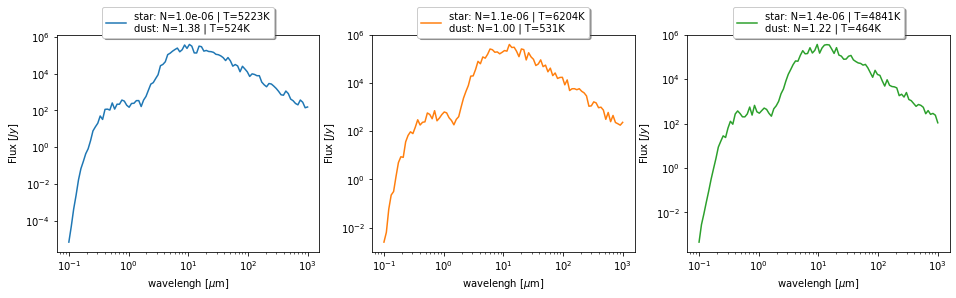

In [143]:
colors = cm.tab10(np.linspace(0, 1, 10))

n_cols = 3
fig, axes = plt.subplots(1, n_cols, figsize=(16,4)) 

for i in range(n_cols):
    ax = axes[i]
    spectrum = X[i]
    metadata = Y[i]
    T_star = metadata['T_star']
    N_star = metadata['N_star']
    T_dust = metadata['T_dust']
    N_dust = metadata['N_dust']
    
    label = str('%4s: N=%-6.1e | T=%sK\n%4s: N=%-4.2f | T=%sK' %
                ("star", N_star, T_star,"dust", N_dust, T_dust))

    ax.plot(wave_mu, spectrum, label=label, c=colors[i])

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('wavelengh [$\mu$m]')
    ax.set_ylabel('Flux [$Jy$]')
    
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
               ncol=2, fancybox=True, shadow=True)            
    
plt.show()    

## Preparing data

### Splitting

In [150]:
# Splitting dataset into train/validation/test sets:
X_rest, X_test, Y_rest, Y_test = train_test_split(X, Y, test_size=0.1, random_state=1)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_rest, Y_rest, test_size=0.3, random_state=1)

del X_rest
# purging exploited variable to save memory

table = PrettyTable()
table.title = 'Train/valid/test data shape'
table.field_names = ['', 'X', 'y']
table.add_row(['train', np.shape(X_train), np.shape(Y_train)])
table.add_row(['valid', np.shape(X_valid), np.shape(Y_valid)])
table.add_row(['test', np.shape(X_test), np.shape(Y_test)])
print(table)

+-------------------------------+
|  Train/valid/test data shape  |
+-------+-------------+---------+
|       |      X      |    y    |
+-------+-------------+---------+
| train | (6300, 100) | (6300,) |
| valid | (2700, 100) | (2700,) |
|  test | (1000, 100) | (1000,) |
+-------+-------------+---------+


### Scaling

We want to constrain the data within a small dynamic range, to help the gradient descent.

We will spectra fluxes using a simple log10:

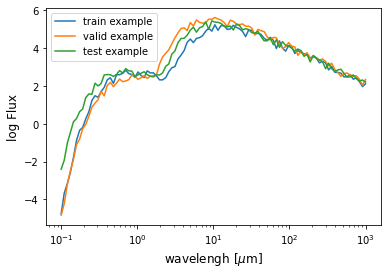

In [156]:
def normalize(X):
    X_n = np.log10(X)
    return X_n

X_n_train = normalize(X_train)
X_n_valid = normalize(X_valid)
X_n_test  = normalize(X_test)

plt.plot(wave_mu, X_n_train[0], label='train example')
plt.plot(wave_mu, X_n_valid[0], label='valid example')
plt.plot(wave_mu, X_n_test[0], label='test example')
plt.xscale('log')

plt.xlabel('wavelengh [$\mu$m]', fontsize=12)
plt.ylabel('log Flux', fontsize=12)
plt.legend()
plt.show()

Seem good. Let's procceed.

# Autoencoder

<img src="images/autoencoder.png"/>

In [157]:
# Packages for autoencoder:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam

# Packages for Black-Body function:
from astropy.modeling.models import BlackBody
from astropy import units as u
from astropy.visualization import quantity_support

In [6]:
from keras import backend as K

def BuildSpectrum(x):
    '''
    Returns a composite Black Body, resulting from the sum of two Planck
    functions:
    - a BB representing the stellar component
    - a BB representing the dust    component
    
    Parameters
    ----------
    x : tensor
        Layer with 4 neurons, representing, in order:
            x[0] = T_star
            x[1] = N_star
            x[2] = T_dust
            x[3] = N_dust
    
    Returns
    -------
    BB_log10 : tensor
        Composite BB_star + BB_dust spectrum
    '''
        
    wave_cm = wave_mu * 1e-4 # cm
    wave_cm = tf.expand_dims(wave_cm, axis=0)

    T_star = tf.gather(x, [0], axis=-1)
    N_star = tf.gather(x, [1], axis=-1)
    T_dust = tf.gather(x, [2], axis=-1)
    N_dust = tf.gather(x, [3], axis=-1)

    # Casting type float32->float64 to increase numerical accuracy:
    # (required to properly calculate the tails of the BB)
    T_star = tf.cast(T_star, tf.float64)
    N_star = tf.cast(N_star, tf.float64)
    T_dust = tf.cast(T_dust, tf.float64)
    N_dust = tf.cast(N_dust, tf.float64)

    def BB(wave_cm, T, N):
        '''
        Returns a Black Body function evaluated over the <wave_cm> array, in:
            ergs/s/cm^2/Hz/sr

        Reproduces exactly the function defined as in:
            https://docs.astropy.org/en/stable/api/astropy.modeling.physical_models.BlackBody.html
        '''

        c = 3e10 # cm/sec
        freq_Hz = c / wave_cm
        h = 6.6261e-27 # cgs
        k = 1.3807e-16 # cgs

        ones = tf.cast(tf.ones(tf.size(wave_cm)), tf.float64)
        numerator   = 2*h*tf.pow(freq_Hz,3)/c**2
        denominator = tf.math.exp(h*freq_Hz/(k*T)) - ones

        eps= 1e-20
        # small additive constant to avoid numerical issues
        
        BB = N * numerator / denominator + eps
        #tf.print(BB)
        
        return BB
        
    BB_star = BB(wave_cm, T_star, N_star)
    BB_dust = BB(wave_cm, T_dust, N_dust)

    # Converting into flux density:
    sr = 1e-10
    # steradiants to convert ergs/s/cm^2/Hz/sr -> ergs/s/cm^2/Hz
    # (this is the same arbitrary value used when the spectra were generated)
    cgs_to_Jy = 1e-23
    # conversion factor for flux from ergs/s/cm^2/Hz -> Jansky

    BB_star = BB_star * sr / cgs_to_Jy
    BB_dust = BB_dust * sr / cgs_to_Jy

    BB = tf.add(BB_star, BB_dust)

    # Normalization:
    BB_log10 = tf.experimental.numpy.log10(BB)
    
    return BB_log10

In [43]:
from keras import backend as K

def CustomActivationFunction(x) :
    '''
    Custom activation function for the last layer of the Encoder.
    
    This activation shall transform the input it received to values that
    resemble plausible T_star, N_star, T_dust, and N_dust.

    Parameters
    ----------
    x : tensor
        A 4 neurons layer.
    
    Returns
    -------
    x_activated : tensor
        A layer with 4 neurons, that have the meaning of T_star, N_star,
        T_dust, and N_dust.
    
    '''
    # https://stackoverflow.com/questions/44553722/restricting-the-output-values-of-layers-in-keras

    tf.print('CustomAct: x', x[0,:])

    # Grabbing layer's neuron values:
    T_star = tf.gather(x, [0], axis=-1)
    N_star = tf.gather(x, [1], axis=-1)
    T_dust = tf.gather(x, [2], axis=-1)
    N_dust = tf.gather(x, [3], axis=-1)

    # Scaling around reasonable expected values: we want the neurons to be
    #   able to range within physically plausible values for T_star, N_star,
    #   T_dust, and N_dust .
    #
    # The input to this function can be any arbitrary set of 4 floats, so
    #   we need to "enforce" the ranges.
    # 
    #   - First, we use the K.sigmoid() function first to scales the values
    #     between 0 and 1
    #
    #   - Second, we multiply by a reasonable expected value for T_star,
    #     N_star, T_dust, and N_dust 
    #
    #   - Third, we multiply by 2 (or 3) to extend the range to +/-100%
    #     (+/-150%) around the expected value
    #
    #   - Finally, we add a small constant (epsilon) to avoid 0s, which would
    #     cause numerical issues
    #
    #   In this way, we set the range that the network can explore for each
    #     parameter.  Backpropagation will take care of pushing them towards
    #     the correct values.
    #
    epsilon = 1e-7
    T_star = 2*K.sigmoid(T_star)*6000  + epsilon
    N_star = 3*K.sigmoid(N_star)*1e-6  + epsilon
    T_dust = 2*K.sigmoid(T_dust)*500   + epsilon
    N_dust = 2*K.sigmoid(N_dust)*1e0   + epsilon

    x_activated = K.concatenate([T_star,N_star,T_dust,N_dust], axis=-1)

    #tf.print('CustomAct: x_act', x_activated[0,:])
    
    return x_activated

In [44]:
# Autoencoder: 
#     https://stackabuse.com/autoencoders-for-image-reconstruction-in-python-and-keras/
# Lambda layer:
#     https://keras.io/api/layers/core_layers/lambda/

# Batch normalization - theory:
#    https://datascience.stackexchange.com/questions/53426/what-exactly-is-batchnormalization-in-keras
# application:
#    https://stackoverflow.com/questions/34716454/where-do-i-call-the-batchnormalization-function-in-keras

from tensorflow.keras.layers import Dense, Input, InputLayer, Lambda, Activation
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import activations

n_inputs = X.shape[1]
n_latent = 4

def build_autoencoder(n_inputs, n_latent):
    # The encoder
    encoder = Sequential()
    encoder.add(InputLayer(n_inputs))
    #
    encoder.add(Dense(n_inputs))
    encoder.add(BatchNormalization())
    encoder.add(Activation('relu'))
    encoder.add(Dense(n_inputs/2))
    encoder.add(BatchNormalization())
    encoder.add(Activation('relu'))
    encoder.add(Dense(n_inputs/4))
    encoder.add(BatchNormalization())
    # Do not touch the following layers:
    encoder.add(Activation('sigmoid'))
    encoder.add(Dense(n_latent, activation=CustomActivationFunction))

    # The decoder
    decoder = Sequential()
    decoder.add(InputLayer((n_latent,)))
    #
    decoder.add(Lambda(BuildSpectrum))

    decoder.layers[-1].trainable = False
    # not necessary, just here for redundancy
    
    return encoder, decoder

encoder, decoder = build_autoencoder(n_inputs, n_latent)

print(encoder.summary())
print(decoder.summary())

inp = Input(n_inputs)
encoded = encoder(inp)
reconstruction = decoder(encoded)

model = Model(inp, reconstruction)

# Compiling autoencoder model:
#opt = SGD(learning_rate=0.01, momentum=0.9, clipvalue=0.5)
opt = Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.5, epsilon=1e-07,
            amsgrad=False, name='Adam')
model.compile(optimizer=opt, run_eagerly=False, loss='mae')
# NOTE: run_eagerly=True allows to convert tensors to numpys
#       (useful for testing but less efficient)
#K.set_value(model.optimizer.learning_rate, 0.0001)
# default Keras learning rate = 0.001

weights_init = model.get_weights()
# saving initialization weights

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 100)               10100     
                                                                 
 batch_normalization_9 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                                 
 activation_9 (Activation)   (None, 100)               0         
                                                                 
 dense_13 (Dense)            (None, 50)                5050      
                                                                 
 batch_normalization_10 (Bat  (None, 50)               200       
 chNormalization)                                                
                                                                 
 activation_10 (Activation)  (None, 50)               

Epoch 1/100
CustomAct: x [-1.1121316 -0.118212953 0.133556858 -0.347416401]
CustomAct: x [-0.452132702 0.654945612 0.0476411134 -0.766032457]
CustomAct: x [-0.679988 0.585948467 0.0483416505 -0.423249841]
CustomAct: x [-1.01221442 0.0374608375 0.324444473 -0.485438198]
CustomAct: x [-0.648692131 0.568765461 -0.174129978 -0.159671172]
CustomAct: x [-0.376125872 0.90798974 0.0715479404 -0.555857062]
CustomAct: x [-0.92888236 -0.0119819436 -0.379510909 -0.076083146]
CustomAct: x [-0.653428435 0.122389644 -0.255247146 -0.840485632]
CustomAct: x [-1.18050265 0.000274129794 0.171141207 -0.700555086]
CustomAct: x [-1.03098702 -0.0278305877 0.333249211 -0.472739369]
CustomAct: x [-0.450558037 0.521403193 -0.304144621 -0.431790113]
CustomAct: x [-0.775919676 0.162961319 -0.163221255 -0.341932863]
CustomAct: x [-0.899071038 0.0921272 -0.31625545 -0.536825061]
CustomAct: x [-1.32461798 -0.38485691 0.412900597 -0.640091538]
CustomAct: x [-0.681536198 0.41673249 -0.306837171 -0.305863768]
CustomAct

CustomAct: x [-1.11210418 0.142938554 1.03259611 0.284010351]
CustomAct: x [-1.38684273 -0.0350050144 1.11402643 0.214134797]
CustomAct: x [-1.22213674 -0.0520369597 1.00784361 0.287938505]
CustomAct: x [-0.983631313 0.168983668 0.94190836 0.271957099]
CustomAct: x [-1.20618939 0.0977511406 1.11369669 0.352796525]
CustomAct: x [-1.05949235 0.113384113 1.04819047 0.259119213]
CustomAct: x [-1.46027148 -0.139325246 1.2217772 0.196968108]
CustomAct: x [-1.27277744 0.000976091251 1.1462872 0.216230392]
CustomAct: x [-0.946393549 0.33382386 1.02065563 0.333336473]
CustomAct: x [-1.16722345 0.0359604061 0.988842726 0.307588488]
CustomAct: x [-1.01909399 0.226936802 1.01501369 0.262826562]
CustomAct: x [-1.08199596 0.143428296 1.04173887 0.260128766]
CustomAct: x [-1.73861909 -0.236313924 1.15946043 0.16059801]
CustomAct: x [-1.25231767 0.062859416 1.03583527 0.247900352]
CustomAct: x [-0.841267467 0.264888436 0.911234 0.260256857]
CustomAct: x [-1.38799238 -0.0709035695 1.20654058 0.19160835

CustomAct: x [-0.266063035 0.747742414 0.0179280359 -0.464186281]
CustomAct: x [-0.740032375 0.614997 0.324372798 -0.373138577]
CustomAct: x [-0.256884396 0.846538603 0.15756844 -0.103074819]
CustomAct: x [-1.2000351 0.138837859 0.242782786 -0.360547066]
CustomAct: x [-0.521281838 0.605268836 0.186500847 -0.0890598744]
CustomAct: x [-0.346354783 0.692863107 -0.0279064327 0.0408850759]
CustomAct: x [-0.380655855 0.841362059 0.166128531 -0.0865245908]
CustomAct: x [-0.455137223 0.64999336 0.348796189 -0.106658205]
CustomAct: x [-0.421651483 0.496009707 -0.378318101 -0.228716016]
CustomAct: x [-0.302242577 0.772337377 0.196117461 -0.117497854]
CustomAct: x [-0.275808 0.837128282 0.138777673 -0.106062457]
CustomAct: x [-0.509338 0.664099932 -0.0381778032 0.00608216133]
CustomAct: x [-0.324676633 0.789363265 -0.102353834 -0.0455270261]
CustomAct: x [-0.556511343 0.511205554 -0.229906276 -0.0680907071]
CustomAct: x [-0.466090739 0.406558454 -0.437965214 -0.234984428]
CustomAct: x [-0.6695435

CustomAct: x [-0.101066478 0.92154 -0.102168374 -0.167056143]
CustomAct: x [0.0165795423 0.983976603 -0.0379130468 -0.114666551]
CustomAct: x [-0.269762933 0.899025202 0.0456964187 0.0348145887]
CustomAct: x [-0.636041462 0.46491909 0.00555464393 -0.278792739]
CustomAct: x [-0.0978269055 0.912000835 -0.132403851 -0.173356384]
CustomAct: x [-0.161553234 0.909946382 -0.0564325 -0.0897159874]
CustomAct: x [-0.288431704 0.790654898 0.118555203 -0.065783821]
CustomAct: x [-0.187093735 0.780265927 -0.239228308 -0.294621408]
CustomAct: x [-0.284738481 0.659521222 -0.448648959 -0.09171924]
CustomAct: x [-0.250697047 0.777962446 -0.229810059 -0.0904195234]
CustomAct: x [-0.0928656831 1.01095796 0.133324936 -0.100729749]
CustomAct: x [-0.100861453 0.927005 0.0555831045 0.0391251184]
CustomAct: x [-0.0818836391 1.01557386 0.136565387 0.0485458]
CustomAct: x [-0.387851298 0.639739752 0.402286083 -0.180728137]
CustomAct: x [-0.407274961 0.615965128 -0.324773818 0.10365586]
CustomAct: x [-0.45200866

CustomAct: x [-0.0372016504 1.25554347 0.625259042 0.28544727]
CustomAct: x [-0.202321261 1.17962492 0.443732858 0.218810499]
CustomAct: x [0.0443686657 1.21627378 0.183592424 0.450574577]
50/50 - 0s - loss: 0.1902 - val_loss: 0.3609 - 229ms/epoch - 5ms/step
Epoch 8/100
CustomAct: x [0.0272019729 0.809671342 -0.0869103521 -0.0538706705]
CustomAct: x [-0.353374332 0.763222396 0.320699304 -0.0600327142]
CustomAct: x [-0.324177563 0.747980118 0.217670158 0.0454394855]
CustomAct: x [0.0369674638 1.00372708 0.0358555168 0.0724827945]
CustomAct: x [-0.170243964 0.799650431 0.0436022356 0.0927669778]
CustomAct: x [0.126307368 1.17794478 0.344680548 0.10090135]
CustomAct: x [-0.70890981 0.192530125 -0.448122561 -0.11497657]
CustomAct: x [-0.463348866 0.44063589 -0.391783744 -0.171815306]
CustomAct: x [0.192877263 0.998452187 -0.0270115659 -0.0652275681]
CustomAct: x [0.123014174 0.871811509 -0.0986195579 -0.205365062]
CustomAct: x [0.148578316 1.0193181 0.00903038 -0.0215825737]
CustomAct: x [

CustomAct: x [-0.0505733602 1.0605247 0.508307517 0.241206571]
CustomAct: x [0.0140973292 1.0469985 0.502213299 0.175560236]
CustomAct: x [0.204379752 1.20911109 0.168609098 0.443358451]
CustomAct: x [-0.151107237 0.946703494 0.40987879 0.183492988]
CustomAct: x [-0.310911268 1.19198525 0.432084 0.255048484]
CustomAct: x [-0.249127507 0.740545452 0.0272488594 0.420890868]
CustomAct: x [0.047326304 1.15438354 0.384743154 0.364224732]
CustomAct: x [-0.337702423 1.03182912 0.359985828 0.292238772]
CustomAct: x [-0.128764287 0.973797679 0.312724769 0.272535682]
CustomAct: x [-0.498356819 0.779170692 0.246138513 0.172820598]
CustomAct: x [-0.234891057 0.995604455 0.382138669 0.216017038]
CustomAct: x [-0.0958352834 1.08982635 0.453023 0.295548588]
CustomAct: x [-0.247687608 0.860473216 0.0855914 0.514435053]
CustomAct: x [-0.151311964 0.926812232 0.482935518 0.303049296]
CustomAct: x [-0.112062857 0.885822892 0.261026829 0.225827441]
CustomAct: x [-0.693776727 0.879865229 0.323810041 0.1695

CustomAct: x [-0.217234269 0.544645309 0.242972463 0.15634647]
CustomAct: x [-0.49406442 0.269988149 0.00780089805 0.0102030281]
CustomAct: x [0.252536565 0.662430823 -0.202092499 -0.185786083]
CustomAct: x [0.169294477 0.706183672 -0.0556348935 -0.184225261]
CustomAct: x [-0.517463565 0.485866785 0.295092285 -0.0638790429]
CustomAct: x [0.10271275 0.824578226 0.187283054 0.0147406366]
CustomAct: x [-0.742073596 0.173519388 0.0603173785 -0.0280287974]
CustomAct: x [-0.200951606 0.433698565 0.140727758 0.0484410748]
CustomAct: x [-0.129369617 0.47921446 -0.0854599178 0.17355302]
CustomAct: x [-0.108646296 0.657921612 0.0957438201 0.0913524255]
CustomAct: x [-0.188296556 0.477330625 0.300747275 0.0437761098]
CustomAct: x [-0.299738556 0.128883258 -0.427102476 -0.12040624]
CustomAct: x [0.0129015688 0.651734173 0.130021185 0.0685456842]
CustomAct: x [0.50538826 1.05125749 0.0073957108 0.174929634]
CustomAct: x [-0.355004758 0.339241534 -0.0516562685 0.0800685]
CustomAct: x [0.0108459648 0

CustomAct: x [0.342740089 0.660783291 -0.12659654 0.00653589331]
CustomAct: x [0.332843 0.748090446 0.0287296213 0.0784778073]
CustomAct: x [0.00164484233 0.500468135 -0.0561462231 -0.110623844]
CustomAct: x [0.139079317 0.601014376 -0.164747477 0.0249698311]
CustomAct: x [0.396439582 0.799972892 -0.0491355136 0.0349776968]
CustomAct: x [-0.0520630814 0.600202918 0.0435731448 0.153913051]
CustomAct: x [-0.493168026 0.0766460523 -0.0182736814 -0.0709787458]
CustomAct: x [0.166629508 0.602740169 -0.101910144 -0.0217176303]
CustomAct: x [-0.0398672223 0.491735905 -0.0991058424 0.0267418921]
CustomAct: x [-0.119741425 0.420003831 0.117010981 -0.0114826635]
CustomAct: x [0.0707555115 0.410641372 -0.225321144 -0.17939654]
CustomAct: x [-0.0901159644 0.223432854 -0.430207342 0.0184128731]
CustomAct: x [-0.11645598 0.27518189 -0.243209913 -0.0398541614]
CustomAct: x [0.116509959 0.68892169 0.104406931 0.00468997285]
CustomAct: x [0.042463053 0.560121179 0.0317607708 0.141106308]
CustomAct: x [

CustomAct: x [-0.279533088 0.430840552 0.309942126 0.229873329]
CustomAct: x [0.103412792 0.781316876 0.187427953 0.625960886]
CustomAct: x [-0.32263273 0.32914561 0.156367347 0.183230683]
CustomAct: x [0.0914242119 0.871554434 0.339232534 0.439783931]
CustomAct: x [-0.173614234 0.432168961 0.115939476 0.401306897]
CustomAct: x [0.129371613 0.545482814 -0.0932925865 0.451546878]
50/50 - 0s - loss: 0.1521 - val_loss: 0.2107 - 229ms/epoch - 5ms/step
Epoch 15/100
CustomAct: x [0.160147786 0.422816932 -0.120284989 0.0480936728]
CustomAct: x [-0.356647491 0.264150709 0.282116532 -0.00706616044]
CustomAct: x [-0.288171858 0.347294688 0.250061929 0.0874989703]
CustomAct: x [0.109147429 0.591184139 0.00703491 0.140207082]
CustomAct: x [-0.12593472 0.297471106 0.0410464108 0.0846707523]
CustomAct: x [0.235950842 0.848727286 0.345497519 0.0814604461]
CustomAct: x [-0.608966231 -0.271221727 -0.437509894 0.0203928854]
CustomAct: x [-0.381908864 -0.0993670672 -0.421834767 -0.132669061]
CustomAct: x

CustomAct: x [0.0442832336 0.348371178 -0.10550911 0.182965815]
CustomAct: x [-0.352389127 -0.177450448 -0.254873246 -0.0384150296]
CustomAct: x [-0.176627547 -0.225487962 -0.450068533 -0.129861936]
CustomAct: x [-0.513167262 -0.142053545 -0.123784661 -0.0308380611]
CustomAct: x [-0.161680803 0.608943701 0.470954 0.353220016]
CustomAct: x [-0.139955923 0.620304525 0.424184769 0.303933054]
CustomAct: x [0.149532974 0.623058438 0.0656661913 0.593799114]
CustomAct: x [-0.225483984 0.486811846 0.351078272 0.303089499]
CustomAct: x [-0.502138257 0.415489584 0.411687404 0.224372298]
CustomAct: x [-0.0942646 0.112766296 -0.127152786 0.370483667]
CustomAct: x [0.00437870622 0.62517035 0.228681967 0.529549122]
CustomAct: x [-0.229099154 0.311171472 0.18029663 0.246764377]
CustomAct: x [-0.0951314569 0.381699681 0.10992717 0.380322427]
CustomAct: x [-0.291364521 0.0724878 -0.0428969041 -0.0400080197]
CustomAct: x [-0.292595208 0.308350503 0.314226896 0.235960871]
CustomAct: x [-0.19634369 0.6321

CustomAct: x [0.0427504331 0.250261873 0.0424492359 0.147169262]
CustomAct: x [0.382236689 0.625898421 0.136400893 0.117548198]
CustomAct: x [-0.254158199 0.0532410443 0.334385 -0.00219802558]
CustomAct: x [-0.176407561 -0.262610972 -0.275203258 -0.00174181536]
CustomAct: x [-0.295109749 -0.127692863 0.157565057 0.0791682228]
CustomAct: x [-0.190253496 0.156559333 0.262039453 0.145990252]
CustomAct: x [-0.46667695 -0.16864711 -0.011146985 0.0327613614]
CustomAct: x [0.320932657 0.218397021 -0.224217594 -0.181173488]
CustomAct: x [0.196155384 0.234388053 -0.0532226562 -0.183767185]
CustomAct: x [-0.524771273 0.0176924728 0.303053945 -0.0552485473]
CustomAct: x [0.121370524 0.409345955 0.182580069 0.00995261408]
CustomAct: x [-0.669731677 -0.254524708 0.0532077141 0.0533314832]
CustomAct: x [-0.163277209 0.00611887313 0.151258066 0.0361435041]
CustomAct: x [-0.0958515704 0.00708503835 -0.0777507722 0.134724095]
CustomAct: x [-0.0796038657 0.213518113 0.0911142603 0.0853767395]
CustomAct:

CustomAct: x [-0.598818421 -0.557649136 -0.430975676 0.0324002244]
CustomAct: x [-0.346133739 -0.416316539 -0.430429429 -0.134829029]
CustomAct: x [0.536928773 0.477108508 -0.0426361971 0.00188229233]
CustomAct: x [0.286464393 0.146928668 -0.12888661 -0.142454967]
CustomAct: x [0.320022821 0.373795956 0.0575512685 -0.0219358802]
CustomAct: x [-0.39234364 -0.335730791 0.0387494341 -0.0854716524]
CustomAct: x [0.378981799 0.20722422 -0.123903267 -0.00713614374]
CustomAct: x [0.396294683 0.372758567 0.0158936717 0.100797854]
CustomAct: x [0.0336435102 0.0103815161 -0.0540972054 -0.157710433]
CustomAct: x [0.168631464 0.141454697 -0.161676377 0.056176886]
CustomAct: x [0.414690375 0.405599415 -0.0381181948 0.0553786345]
CustomAct: x [-0.0212626047 0.185310289 0.0632225573 0.165643275]
CustomAct: x [-0.457006156 -0.332446843 -0.0348216891 -0.0296171233]
CustomAct: x [0.19097954 0.151038513 -0.0961584821 -0.00714324787]
CustomAct: x [-0.0155017301 0.0178005546 -0.0957050174 0.000314358622]
C

CustomAct: x [-0.0436145328 0.0390943401 0.0265218113 0.383369148]
CustomAct: x [-0.308667362 -0.284973353 -0.116602197 -0.0211136378]
CustomAct: x [-0.272996694 -0.0409291722 0.228289068 0.321020216]
CustomAct: x [-0.178981498 0.308566481 0.394762367 0.460731715]
CustomAct: x [-0.0588547103 -0.161730513 -0.156942129 0.383087873]
CustomAct: x [-0.130109131 0.142095506 0.314147353 0.415732861]
CustomAct: x [-0.13518922 -0.0459788069 -0.010074649 0.264885545]
CustomAct: x [-0.6840837 -0.345848739 0.113923945 0.109005295]
CustomAct: x [-0.223598376 -0.102532387 0.146877229 0.350785971]
CustomAct: x [0.154699817 0.363807797 0.12804845 0.640004575]
CustomAct: x [-0.300170541 -0.174175546 0.0356063172 0.210569784]
CustomAct: x [0.147564068 0.439840376 0.287868679 0.490916878]
CustomAct: x [-0.0566348545 -0.052515313 -0.0437783636 0.436772436]
CustomAct: x [0.228752315 0.0287881829 -0.15916422 0.357287258]
50/50 - 0s - loss: 0.1399 - val_loss: 0.1662 - 227ms/epoch - 5ms/step
Epoch 22/100
Cust

CustomAct: x [0.13550812 0.122493148 0.189201415 0.00130255148]
CustomAct: x [-0.636456311 -0.507239 0.0523557 0.0876448452]
CustomAct: x [-0.132522702 -0.283144474 0.143271863 0.0315451324]
CustomAct: x [-0.0765638798 -0.285519391 -0.067035839 0.124104924]
CustomAct: x [-0.0578636751 -0.073851 0.0879042894 0.0760756]
CustomAct: x [-0.120901078 -0.193745315 0.306053728 0.0110967197]
CustomAct: x [-0.291611075 -0.652750671 -0.447397381 -0.0973420739]
CustomAct: x [0.0181045979 -0.054852508 0.145442769 0.0775855631]
CustomAct: x [0.611151397 0.485065699 0.023929961 0.27899605]
CustomAct: x [-0.294734806 -0.387104481 -0.0238935724 0.0333421789]
CustomAct: x [0.0886738747 -0.0652524531 -0.111684784 0.195714936]
CustomAct: x [-0.314783931 -0.579382539 -0.246978551 -0.0524452105]
CustomAct: x [-0.135667145 -0.643851221 -0.453786582 -0.125751764]
CustomAct: x [-0.495039731 -0.51391089 -0.122559115 -0.0131586157]
CustomAct: x [-0.0907011181 0.226364732 0.455134153 0.401028812]
CustomAct: x [-0

CustomAct: x [0.195673198 -0.142917842 -0.16144304 0.0764141753]
CustomAct: x [0.442388982 0.139400303 -0.0373016633 0.0628261268]
CustomAct: x [0.0011036694 -0.0815815777 0.0679358542 0.170243174]
CustomAct: x [-0.436541855 -0.574802876 -0.0404716656 -0.0164963119]
CustomAct: x [0.21450299 -0.131258681 -0.0932222903 0.00118336082]
CustomAct: x [0.00372649357 -0.288896412 -0.0908678398 -0.0311913714]
CustomAct: x [-0.0567985922 -0.269948602 0.131620541 -0.0400966443]
CustomAct: x [0.133003876 -0.350922585 -0.197145939 -0.199516684]
CustomAct: x [-0.0327566415 -0.509763598 -0.430848926 -0.0307018273]
CustomAct: x [-0.0572499447 -0.494389772 -0.204774335 -0.143021375]
CustomAct: x [0.155642897 -0.0379918814 0.100916684 -0.0681152195]
CustomAct: x [0.0578196123 -0.1412099 0.0497540496 0.151397511]
CustomAct: x [0.440431654 0.242743164 0.138617 0.0839307457]
CustomAct: x [-0.23090294 -0.318235 0.334974319 -0.00408056]
CustomAct: x [-0.148269325 -0.727829337 -0.260467589 -0.025331337]
Custo

CustomAct: x [0.173091069 0.0405159146 0.120625906 0.657711565]
CustomAct: x [-0.299531221 -0.456669152 0.0171353593 0.175787717]
CustomAct: x [0.17134653 0.128048927 0.28486 0.52662605]
CustomAct: x [-0.0354359411 -0.351677358 -0.0651104152 0.454257756]
CustomAct: x [0.282402128 -0.289904237 -0.19892177 0.338458687]
50/50 - 0s - loss: 0.1337 - val_loss: 0.1489 - 234ms/epoch - 5ms/step
Epoch 27/100
CustomAct: x [0.238017112 -0.22863999 -0.130196393 0.103461832]
CustomAct: x [-0.318359822 -0.462434322 0.281061381 -0.0658677071]
CustomAct: x [-0.250528038 -0.311451405 0.264904171 0.0757276565]
CustomAct: x [0.1641545 -0.0580037087 0.00342895091 0.178285435]
CustomAct: x [-0.0726636276 -0.382655382 0.0575588159 0.0193690695]
CustomAct: x [0.264707565 0.198790818 0.360064596 0.0447069369]
CustomAct: x [-0.579725385 -0.873244643 -0.436619401 0.0619283803]
CustomAct: x [-0.302906692 -0.737852514 -0.440989554 -0.124103971]
CustomAct: x [0.590237 0.0755335242 -0.0261569023 -0.0294468775]
Custo

CustomAct: x [-0.27959913 -0.595144749 -0.0205775574 0.0203825347]
CustomAct: x [0.116877235 -0.301148713 -0.112781167 0.209389]
CustomAct: x [-0.294183314 -0.774480164 -0.25013119 -0.0564527921]
CustomAct: x [-0.108309172 -0.864899 -0.453572601 -0.108904898]
CustomAct: x [-0.485876977 -0.696303666 -0.113629967 -0.0111973993]
CustomAct: x [-0.0330959745 -0.0445734859 0.431750685 0.445596486]
CustomAct: x [-0.0182569586 -0.0375271253 0.394341439 0.379884303]
CustomAct: x [0.229242891 -0.142630786 -0.0223868191 0.511484802]
CustomAct: x [-0.123559 -0.262376577 0.231113523 0.423679769]
CustomAct: x [-0.473582715 -0.372967958 0.283031613 0.308963418]
CustomAct: x [-0.0478937216 -0.655100644 -0.219913721 0.269642144]
CustomAct: x [0.102912679 -0.0362158604 0.157382056 0.657039762]
CustomAct: x [-0.178078309 -0.495499402 -0.0166070648 0.350666046]
CustomAct: x [-0.0145062245 -0.368496656 -0.0535628237 0.434777498]
CustomAct: x [-0.333785504 -0.659751475 -0.167246416 0.0250688139]
CustomAct: 

CustomAct: x [-0.000663135201 -0.732397914 -0.429751575 -0.0443586335]
CustomAct: x [-0.0343247689 -0.697259963 -0.19201532 -0.173750758]
CustomAct: x [0.174492225 -0.279255331 0.108020641 -0.106598161]
CustomAct: x [0.0719874576 -0.35724625 0.0532584488 0.159713209]
CustomAct: x [0.477303147 -0.00156927109 0.141338378 0.056442339]
CustomAct: x [-0.217504531 -0.541516185 0.336971611 -0.0156491436]
CustomAct: x [-0.123077936 -0.979501903 -0.256079733 -0.0287116095]
CustomAct: x [-0.226723179 -0.819600821 0.178934932 -0.000690866262]
CustomAct: x [-0.154285669 -0.437275916 0.27368629 0.116468906]
CustomAct: x [-0.436936438 -0.696654797 -0.0173212588 0.0253735464]
CustomAct: x [0.399727881 -0.403349191 -0.223054394 -0.195576146]
CustomAct: x [0.25834626 -0.424145728 -0.0312618539 -0.243839771]
CustomAct: x [-0.510076761 -0.595617056 0.315365613 -0.103551097]
CustomAct: x [0.153426841 -0.217144519 0.198081672 -0.0062526986]
CustomAct: x [-0.605086088 -0.768789172 0.0496391058 0.123968087]


CustomAct: x [-0.30312252 -0.674960792 0.292294621 -0.0943442434]
CustomAct: x [-0.236982495 -0.525521517 0.262391418 0.0668192208]
CustomAct: x [0.18310377 -0.249869198 0.00120534189 0.195264727]
CustomAct: x [-0.0557091385 -0.574122071 0.0637696758 -0.00115871802]
CustomAct: x [0.278597057 -0.0234340094 0.374397635 0.0206808485]
CustomAct: x [-0.569921136 -1.02103841 -0.435151428 0.0811280161]
CustomAct: x [-0.285115689 -0.867776692 -0.444074452 -0.121581525]
CustomAct: x [0.622424185 -0.162275314 -0.0167587288 -0.0551840477]
CustomAct: x [0.350393802 -0.417372525 -0.121929117 -0.16331318]
CustomAct: x [0.403140217 -0.241261303 0.0867097452 -0.120587543]
CustomAct: x [-0.351178765 -0.856440961 0.0560678951 -0.104689255]
CustomAct: x [0.448676616 -0.454224586 -0.125925735 -0.0378638878]
CustomAct: x [0.484126151 -0.210773051 0.0185161754 0.110957518]
CustomAct: x [0.107831553 -0.618119717 -0.0137517964 -0.260073602]
CustomAct: x [0.223555923 -0.431392103 -0.163563207 0.108490691]
Cust

CustomAct: x [0.279112339 -0.32112211 -0.0408841334 0.445412904]
CustomAct: x [-0.0802052915 -0.484192729 0.199213371 0.370504707]
CustomAct: x [-0.436695695 -0.579680145 0.261014968 0.283731639]
CustomAct: x [-0.0481953174 -0.832570374 -0.214247391 0.214495927]
CustomAct: x [0.141837955 -0.231230378 0.109244838 0.621040881]
CustomAct: x [-0.156836182 -0.695652962 -0.00404254254 0.272331834]
CustomAct: x [0.012425594 -0.541176677 -0.0658024848 0.391605496]
CustomAct: x [-0.333885968 -0.788429618 -0.15034014 0.0234586634]
CustomAct: x [-0.214027286 -0.698705375 0.114511542 0.346129715]
CustomAct: x [-0.064479582 -0.408985257 0.322604746 0.565354109]
CustomAct: x [-0.0210580826 -0.757862 -0.21534355 0.297783077]
CustomAct: x [-0.0325748175 -0.444636345 0.198248953 0.458614945]
CustomAct: x [-0.0797557086 -0.611104786 -0.0640351251 0.147864237]
CustomAct: x [-0.612834513 -0.903177798 0.102893814 0.0857401043]
CustomAct: x [-0.155944362 -0.761931717 0.0143465921 0.367977589]
CustomAct: x [

CustomAct: x [-0.199542791 -1.01258361 0.188600034 -0.0398528688]
CustomAct: x [-0.14338924 -0.59626317 0.277606159 0.102505788]
CustomAct: x [-0.431225538 -0.80955404 -0.0177207217 0.0222959705]
CustomAct: x [0.42766279 -0.56028372 -0.222663701 -0.206066698]
CustomAct: x [0.278648019 -0.603748262 -0.0223707892 -0.277095705]
CustomAct: x [-0.501643181 -0.736733556 0.321768016 -0.122797504]
CustomAct: x [0.166346565 -0.390045524 0.204278 -0.0144961849]
CustomAct: x [-0.595848143 -0.877853811 0.0525285117 0.142778531]
CustomAct: x [-0.0776179135 -0.858618796 0.125881284 0.0573289134]
CustomAct: x [-0.0490342677 -0.748975396 -0.0549867302 0.127431348]
CustomAct: x [-0.015265774 -0.524530411 0.0796237662 0.0561455563]
CustomAct: x [-0.0755659267 -0.657848358 0.322547495 -0.0565845817]
CustomAct: x [-0.290390581 -0.961159 -0.452526718 -0.0691046566]
CustomAct: x [0.0508602709 -0.514799 0.157558411 0.0667550713]
CustomAct: x [0.708137691 -0.00607063621 0.0289134569 0.326245815]
CustomAct: x 

CustomAct: x [0.371350229 -0.536030412 -0.122816369 -0.173823029]
CustomAct: x [0.435714424 -0.400794655 0.0923631936 -0.169091821]
CustomAct: x [-0.33745712 -0.969975829 0.0649517551 -0.120669656]
CustomAct: x [0.47280702 -0.626279 -0.123086922 -0.0521371104]
CustomAct: x [0.514522135 -0.366618425 0.0188171733 0.116419405]
CustomAct: x [0.133142412 -0.783517 0.00337938219 -0.311287]
CustomAct: x [0.232006788 -0.555586 -0.165183425 0.139545292]
CustomAct: x [0.49967739 -0.288507819 -0.0370810553 0.0828519166]
CustomAct: x [0.041861549 -0.496310055 0.0743446 0.190915689]
CustomAct: x [-0.407278776 -0.922437668 -0.0472600497 -0.00362212583]
CustomAct: x [0.263526142 -0.560995698 -0.0919701755 0.0137752499]
CustomAct: x [0.043497216 -0.723060369 -0.0777805299 -0.0882917494]
CustomAct: x [-0.0163734592 -0.687917888 0.138922036 -0.0702511594]
CustomAct: x [0.194510072 -0.852190137 -0.182091475 -0.258268923]
CustomAct: x [0.0261273 -0.930115938 -0.42842108 -0.0442351922]
CustomAct: x [-0.012

CustomAct: x [-0.0460422672 -0.593440235 0.301426232 0.572271109]
CustomAct: x [-0.0132709034 -0.866296351 -0.225479886 0.263310671]
CustomAct: x [-0.0112387687 -0.571090162 0.17559056 0.443248391]
CustomAct: x [-0.0648661554 -0.673606277 -0.0701317787 0.0672683865]
CustomAct: x [-0.592485309 -0.999744654 0.104385011 0.0553076]
CustomAct: x [-0.139742851 -0.887463689 0.00892959069 0.34713757]
CustomAct: x [0.240281552 -0.456005454 0.0471364483 0.616064608]
CustomAct: x [-0.263042957 -0.816004455 0.0097870063 0.121571586]
CustomAct: x [0.226727322 -0.39813447 0.222410634 0.48220259]
CustomAct: x [0.00680286065 -0.778590798 -0.110972 0.362380475]
CustomAct: x [0.361446202 -0.683410168 -0.249332085 0.287117302]
50/50 - 0s - loss: 0.1269 - val_loss: 0.1311 - 228ms/epoch - 5ms/step
Epoch 39/100
CustomAct: x [0.278399915 -0.547334373 -0.145641834 0.190115228]
CustomAct: x [-0.2897349 -0.869966209 0.303799093 -0.130253136]
CustomAct: x [-0.224802956 -0.730345547 0.25754267 0.054510057]
Custom

CustomAct: x [-0.00537416711 -0.611796796 0.0787684545 0.0483921394]
CustomAct: x [-0.0647003651 -0.761205912 0.329409033 -0.0876115]
CustomAct: x [-0.288675964 -0.959127307 -0.460639417 -0.0610294603]
CustomAct: x [0.0583474264 -0.616838872 0.161166921 0.0661652088]
CustomAct: x [0.736296773 -0.120581776 0.0278699249 0.348922908]
CustomAct: x [-0.260901093 -0.836811066 -0.00941605307 0.00651079603]
CustomAct: x [0.167186409 -0.615120053 -0.115297973 0.244721189]
CustomAct: x [-0.281238526 -0.944753349 -0.261286259 -0.0629404709]
CustomAct: x [-0.0763492584 -1.10127687 -0.464457244 -0.0169790536]
CustomAct: x [-0.484499604 -0.871175885 -0.0993541405 -0.0269980207]
CustomAct: x [0.0532491729 -0.474495053 0.37251991 0.388992935]
CustomAct: x [0.0618105605 -0.426173091 0.350446463 0.281179726]
CustomAct: x [0.300528675 -0.454975963 -0.0371300131 0.409825176]
CustomAct: x [-0.0612694584 -0.65946126 0.175831616 0.281696737]
CustomAct: x [-0.407874465 -0.707969189 0.256821692 0.267237395]
Cu

CustomAct: x [0.275537521 -0.644351423 -0.0919381306 0.012828432]
CustomAct: x [0.0546642393 -0.800146699 -0.0727609694 -0.10296192]
CustomAct: x [-0.00721080601 -0.782244 0.140356764 -0.085917376]
CustomAct: x [0.209736809 -0.971146941 -0.179328144 -0.285771579]
CustomAct: x [0.0391775221 -0.998855054 -0.43205145 -0.0319213681]
CustomAct: x [-0.00465744 -0.934558809 -0.176086068 -0.240300402]
CustomAct: x [0.217593908 -0.62668246 0.132999748 -0.205067903]
CustomAct: x [0.100551933 -0.659288645 0.0548087172 0.205261245]
CustomAct: x [0.549359262 -0.375816286 0.150225714 -0.0167682879]
CustomAct: x [-0.201621115 -0.847637296 0.341713935 -0.0431211405]
CustomAct: x [-0.070424974 -1.38282573 -0.260597318 -0.0235020891]
CustomAct: x [-0.164163411 -1.20949566 0.197460398 -0.0971224159]
CustomAct: x [-0.133867875 -0.731185913 0.283748984 0.0832679644]
CustomAct: x [-0.427853584 -0.88315171 -0.0185183678 0.0245414488]
CustomAct: x [0.453061879 -0.683894634 -0.223309681 -0.220809579]
CustomAct

CustomAct: x [0.366464436 -0.743761063 -0.2602157 0.229308426]
50/50 - 0s - loss: 0.1256 - val_loss: 0.1282 - 235ms/epoch - 5ms/step
Epoch 44/100
CustomAct: x [0.279131323 -0.576737702 -0.150732502 0.235230893]
CustomAct: x [-0.285965681 -0.951910794 0.308793664 -0.152140737]
CustomAct: x [-0.220473126 -0.822763681 0.257428467 0.0502140746]
CustomAct: x [0.201790914 -0.466368735 -0.00887524057 0.282460213]
CustomAct: x [-0.0377260298 -0.810980797 0.0755861551 -0.0400364883]
CustomAct: x [0.307347983 -0.33473891 0.38566 -0.00644627959]
CustomAct: x [-0.554707289 -1.16240263 -0.426561952 0.117135875]
CustomAct: x [-0.266463906 -0.971648216 -0.441187024 -0.116872601]
CustomAct: x [0.669438243 -0.510991693 0.0117195593 -0.125005126]
CustomAct: x [0.385541469 -0.624569595 -0.126155064 -0.174488425]
CustomAct: x [0.472647846 -0.532345 0.10129685 -0.22953698]
CustomAct: x [-0.323931366 -1.0663718 0.0741087198 -0.144819424]
CustomAct: x [0.497058302 -0.789447367 -0.104687385 -0.0855654478]
Cus

CustomAct: x [0.0675115 -0.564602852 0.374466777 0.332618475]
CustomAct: x [0.0702442229 -0.502168715 0.354232758 0.242199644]
CustomAct: x [0.307871729 -0.47652173 -0.0338214114 0.358585387]
CustomAct: x [-0.0539527647 -0.722041309 0.178571522 0.191506132]
CustomAct: x [-0.397902459 -0.758143246 0.262911081 0.225536108]
CustomAct: x [-0.0460136421 -1.00204873 -0.214283019 0.119925901]
CustomAct: x [0.162228778 -0.485810459 0.0709059834 0.550879955]
CustomAct: x [-0.132809401 -0.86187458 0.00498399884 0.154247656]
CustomAct: x [0.021531038 -0.692262769 -0.0609009564 0.247027144]
CustomAct: x [-0.324929059 -0.860933781 -0.138692319 0.019764103]
CustomAct: x [-0.18256326 -0.903902411 0.12196254 0.276235521]
CustomAct: x [-0.027669128 -0.741473913 0.297878891 0.523640931]
CustomAct: x [-0.0225418247 -0.884693563 -0.211451367 0.165348843]
CustomAct: x [0.0053178221 -0.674800932 0.185259208 0.328029424]
CustomAct: x [-0.0706626922 -0.685726702 -0.0827461705 0.00771023519]
CustomAct: x [-0.5

CustomAct: x [-0.0479922295 -1.52159762 -0.268633634 -0.0167487636]
CustomAct: x [-0.146319598 -1.32855952 0.200301841 -0.126470402]
CustomAct: x [-0.128850132 -0.788964331 0.285565168 0.0681811273]
CustomAct: x [-0.427447528 -0.901021302 -0.0206406713 0.03198722]
CustomAct: x [0.46383822 -0.736757934 -0.221807122 -0.227932841]
CustomAct: x [0.302835524 -0.826272845 -0.0145329991 -0.344475478]
CustomAct: x [-0.502544045 -0.87290591 0.330438703 -0.169800222]
CustomAct: x [0.180488035 -0.615931 0.233020172 -0.0478294939]
CustomAct: x [-0.590161681 -0.971134543 0.0623030663 0.156289876]
CustomAct: x [-0.0321131386 -1.2215395 0.111291781 0.101819441]
CustomAct: x [-0.0389519483 -0.900921047 -0.0534372628 0.17633304]
CustomAct: x [0.00220380723 -0.671248138 0.077868551 0.0291924253]
CustomAct: x [-0.0545113906 -0.847030818 0.341087401 -0.127930164]
CustomAct: x [-0.288526356 -0.910485804 -0.462896198 -0.0454481244]
CustomAct: x [0.0642244071 -0.701941967 0.162248224 0.059204597]
CustomAct: 

CustomAct: x [0.676109374 -0.601613104 0.0213043243 -0.152291268]
CustomAct: x [0.390918285 -0.639180243 -0.130305678 -0.173611671]
CustomAct: x [0.491394579 -0.584502578 0.10442397 -0.256826401]
CustomAct: x [-0.318168849 -1.10868597 0.0795193091 -0.163688019]
CustomAct: x [0.50840354 -0.877309859 -0.0918890536 -0.106920436]
CustomAct: x [0.560977578 -0.538449168 0.0248785354 0.145411193]
CustomAct: x [0.171652123 -1.03314614 0.0371570364 -0.422076404]
CustomAct: x [0.229491204 -0.635073602 -0.175560221 0.222063392]
CustomAct: x [0.514449835 -0.386681616 -0.0439378098 0.125852391]
CustomAct: x [0.0587864853 -0.670127332 0.0834667385 0.209662795]
CustomAct: x [-0.396147281 -1.06091046 -0.0436562672 -0.00919182]
CustomAct: x [0.285198867 -0.703996778 -0.0922307521 0.0187205039]
CustomAct: x [0.0646948814 -0.850445509 -0.0673199669 -0.116223209]
CustomAct: x [0.00235074386 -0.864730179 0.140640199 -0.107566647]
CustomAct: x [0.220729277 -1.09059858 -0.176375434 -0.314548135]
CustomAct: x

CustomAct: x [-0.17458418 -0.963806689 0.1298078 0.205263183]
CustomAct: x [-0.0235927291 -0.888553917 0.30347988 0.452985287]
CustomAct: x [-0.0203007944 -0.826773345 -0.208857328 0.12421371]
CustomAct: x [0.0231923461 -0.744770885 0.189785868 0.226969823]
CustomAct: x [-0.0808413923 -0.651734531 -0.079823032 -0.010993829]
CustomAct: x [-0.567338169 -1.14659917 0.110897191 -0.015043484]
CustomAct: x [-0.132979691 -1.08464038 -0.0149350939 0.255097359]
CustomAct: x [0.274164498 -0.643782496 0.0907286778 0.459402084]
CustomAct: x [-0.252514601 -0.866179347 -0.0125419227 0.116926186]
CustomAct: x [0.253810465 -0.61799711 0.277157396 0.26725921]
CustomAct: x [0.0293344148 -0.985815704 -0.112531312 0.245367676]
CustomAct: x [0.375428259 -0.800275505 -0.263737679 0.168551609]
50/50 - 0s - loss: 0.1243 - val_loss: 0.1255 - 226ms/epoch - 5ms/step
Epoch 51/100
CustomAct: x [0.273255855 -0.581880808 -0.153014377 0.277513295]
CustomAct: x [-0.284447 -1.01540947 0.314341277 -0.181342617]
CustomAc

CustomAct: x [-0.0396074839 -0.919398665 -0.0535459183 0.209672764]
CustomAct: x [0.00362275168 -0.682029128 0.0783275366 0.0119132586]
CustomAct: x [-0.0492401756 -0.882756233 0.348632067 -0.152397245]
CustomAct: x [-0.289335847 -0.869862556 -0.463596165 -0.0401804373]
CustomAct: x [0.0673504323 -0.741376281 0.16304107 0.0486316718]
CustomAct: x [0.768802941 -0.22296226 0.0242419727 0.434218675]
CustomAct: x [-0.255384266 -0.834587932 -0.00485599786 0.0257089846]
CustomAct: x [0.183509678 -0.69689703 -0.120351687 0.290917218]
CustomAct: x [-0.2813932 -0.925035477 -0.265121907 -0.0782836676]
CustomAct: x [-0.0753716305 -1.1347388 -0.483566254 0.108819872]
CustomAct: x [-0.48897 -0.833086669 -0.100541905 -0.0434237048]
CustomAct: x [0.0895220041 -0.70706743 0.390288353 0.208730966]
CustomAct: x [0.0878391564 -0.563471198 0.350524336 0.151788041]
CustomAct: x [0.314544857 -0.444844 -0.0334305614 0.279738665]
CustomAct: x [-0.035778556 -0.847508669 0.168465987 0.109488055]
CustomAct: x [-

CustomAct: x [-0.39460364 -1.09211552 -0.0438638739 -0.00892985053]
CustomAct: x [0.289064974 -0.724901736 -0.0921656638 0.0220220536]
CustomAct: x [0.0680290163 -0.854412735 -0.0642130822 -0.117727339]
CustomAct: x [0.00766821206 -0.902345777 0.141013458 -0.121101215]
CustomAct: x [0.226158917 -1.15237904 -0.174117759 -0.322792292]
CustomAct: x [0.0598655939 -1.06355953 -0.450730085 -0.0152172595]
CustomAct: x [-0.00477721542 -0.955732286 -0.175741717 -0.263600945]
CustomAct: x [0.252436876 -0.79591167 0.147788346 -0.267832667]
CustomAct: x [0.11635264 -0.770210922 0.0486869365 0.232067704]
CustomAct: x [0.58136487 -0.548233151 0.161577314 -0.0714088082]
CustomAct: x [-0.201865777 -0.955605268 0.343038708 -0.0647571683]
CustomAct: x [-0.0172277391 -1.71611667 -0.273257 0.0151535477]
CustomAct: x [-0.13062495 -1.47014606 0.207920223 -0.138534576]
CustomAct: x [-0.123164624 -0.836895585 0.287666321 0.0437538959]
CustomAct: x [-0.42854169 -0.902348816 -0.0261109211 0.0455058739]
CustomAc

CustomAct: x [0.0393285155 -1.05950069 -0.100101724 0.20092988]
CustomAct: x [0.37503922 -0.815850675 -0.269294381 0.139286548]
50/50 - 0s - loss: 0.1235 - val_loss: 0.1240 - 247ms/epoch - 5ms/step
Epoch 56/100
CustomAct: x [0.268266916 -0.572231114 -0.152144521 0.283229709]
CustomAct: x [-0.285230726 -1.03880274 0.31851095 -0.201933026]
CustomAct: x [-0.214339301 -0.96031332 0.264980823 0.0435610563]
CustomAct: x [0.200851411 -0.49667421 -0.0195346028 0.339523196]
CustomAct: x [-0.0298893303 -0.875897408 0.0810987279 -0.0772977471]
CustomAct: x [0.323529035 -0.466884494 0.390349597 -0.0329649895]
CustomAct: x [-0.560029149 -1.1795963 -0.418846607 0.128033802]
CustomAct: x [-0.260704637 -0.952306032 -0.441146433 -0.10314317]
CustomAct: x [0.682774 -0.680308461 0.0278214 -0.168581843]
CustomAct: x [0.389559507 -0.611439288 -0.137333438 -0.162538588]
CustomAct: x [0.502706826 -0.64123106 0.114088446 -0.280302465]
CustomAct: x [-0.313969642 -1.15205264 0.0812955201 -0.180129185]
CustomAct

CustomAct: x [-0.497093737 -0.808930457 -0.10655313 -0.0459844247]
CustomAct: x [0.096624732 -0.795193 0.408291668 0.155436724]
CustomAct: x [0.0936177373 -0.581210494 0.358868062 0.0941718519]
CustomAct: x [0.307418972 -0.410580903 -0.040213123 0.24003081]
CustomAct: x [-0.0318273641 -0.887795508 0.173252583 0.0819124579]
CustomAct: x [-0.413066238 -0.938229084 0.288707852 0.116315022]
CustomAct: x [-0.0429890715 -0.930126309 -0.232636318 0.112050697]
CustomAct: x [0.156416357 -0.567185283 0.108860649 0.408919752]
CustomAct: x [-0.13345553 -0.869704485 0.0156930052 0.0511945747]
CustomAct: x [0.00673731044 -0.68300277 -0.0571670607 0.129817307]
CustomAct: x [-0.328641623 -0.867590845 -0.164766565 0.0369504131]
CustomAct: x [-0.17560111 -1.05167556 0.130227879 0.140216142]
CustomAct: x [-0.0150753073 -1.09683514 0.31467092 0.398455113]
CustomAct: x [-0.02917042 -0.701144278 -0.212765276 0.104648456]
CustomAct: x [0.0386905 -0.783161163 0.188031599 0.149898261]
CustomAct: x [-0.08922570

CustomAct: x [0.00458216667 -1.84230304 -0.277811527 0.0351719484]
CustomAct: x [-0.125623345 -1.55426276 0.210491359 -0.130308509]
CustomAct: x [-0.120943271 -0.853756666 0.288912833 0.029154567]
CustomAct: x [-0.429205447 -0.898691058 -0.0281341672 0.0514106]
CustomAct: x [0.477134764 -0.824563 -0.218287259 -0.233599722]
CustomAct: x [0.304505855 -0.846504927 -0.0226598866 -0.364189386]
CustomAct: x [-0.504682 -0.874999344 0.340351284 -0.250155181]
CustomAct: x [0.186076492 -0.697226107 0.251922369 -0.0892198458]
CustomAct: x [-0.595181882 -0.965628266 0.0626932 0.155421108]
CustomAct: x [0.00235826895 -1.56448126 0.112888053 0.194817826]
CustomAct: x [-0.0402450673 -0.93198365 -0.0534530133 0.237527966]
CustomAct: x [0.000100634992 -0.672856688 0.080163382 -0.0112381633]
CustomAct: x [-0.0441188142 -0.899650097 0.352764279 -0.178196728]
CustomAct: x [-0.291572928 -0.816512525 -0.461733133 -0.0263377633]
CustomAct: x [0.0727912039 -0.779297709 0.166530252 0.0265542753]
CustomAct: x [

CustomAct: x [0.686356604 -0.713776588 0.0280536972 -0.168969184]
CustomAct: x [0.384488761 -0.572358489 -0.143577218 -0.154957876]
CustomAct: x [0.507589 -0.664916754 0.117894307 -0.289268672]
CustomAct: x [-0.310305208 -1.17347407 0.0809199587 -0.183942586]
CustomAct: x [0.538565576 -1.00091803 -0.0875246525 -0.0901315957]
CustomAct: x [0.587157845 -0.570407093 0.0175542347 0.179445282]
CustomAct: x [0.18383646 -1.16008914 0.0539706424 -0.453277409]
CustomAct: x [0.219567388 -0.602746844 -0.179557621 0.224546909]
CustomAct: x [0.506587923 -0.330393612 -0.0444319099 0.150495246]
CustomAct: x [0.0716458336 -0.789333165 0.0903610587 0.18419905]
CustomAct: x [-0.392531633 -1.11857784 -0.0453535952 -0.000284045935]
CustomAct: x [0.293421566 -0.739298046 -0.0913840532 0.0242906492]
CustomAct: x [0.0679267272 -0.838323236 -0.0593543313 -0.12358281]
CustomAct: x [0.0126788579 -0.933048 0.141436279 -0.12935251]
CustomAct: x [0.232999027 -1.22378254 -0.171626315 -0.323543]
CustomAct: x [0.0707

CustomAct: x [-0.00285121799 -1.25306535 0.299041837 0.422340095]
CustomAct: x [-0.032672178 -0.664929867 -0.204323903 0.0945550054]
CustomAct: x [0.0450741649 -0.812155485 0.182688802 0.13313818]
CustomAct: x [-0.0881540477 -0.518245816 -0.0676279 -0.0341628306]
CustomAct: x [-0.564097166 -1.2530787 0.120031416 -0.0127137937]
CustomAct: x [-0.120497823 -1.22289109 -0.00642256718 0.226704657]
CustomAct: x [0.303274482 -0.764292359 0.104526691 0.385953516]
CustomAct: x [-0.256864369 -0.873019457 -0.0166353695 0.116858035]
CustomAct: x [0.271278441 -0.740042925 0.288302 0.192346036]
CustomAct: x [0.0533472709 -1.16665149 -0.0894512758 0.192660093]
CustomAct: x [0.377735376 -0.8634516 -0.271285474 0.107275352]
50/50 - 0s - loss: 0.1225 - val_loss: 0.1223 - 228ms/epoch - 5ms/step
Epoch 63/100
CustomAct: x [0.261815876 -0.555726111 -0.151372746 0.280159742]
CustomAct: x [-0.285313696 -1.05810094 0.322422951 -0.219679177]
CustomAct: x [-0.209368855 -1.00652504 0.268458635 0.0487797186]
Custo

CustomAct: x [-0.00544822216 -0.652495384 0.0810774267 -0.0217456128]
CustomAct: x [-0.0422829539 -0.899173856 0.353399068 -0.193367064]
CustomAct: x [-0.29467535 -0.782578528 -0.464271903 -0.0141153503]
CustomAct: x [0.0759353191 -0.804080904 0.169538349 0.0127427]
CustomAct: x [0.786012 -0.22365196 0.0251135379 0.481008708]
CustomAct: x [-0.253727674 -0.747094333 -0.00812449586 0.0529763475]
CustomAct: x [0.188245803 -0.735965431 -0.118145846 0.282179862]
CustomAct: x [-0.28131479 -0.874730766 -0.266806871 -0.0932060555]
CustomAct: x [-0.0807569176 -1.15590906 -0.502146 0.143172085]
CustomAct: x [-0.50724107 -0.778049648 -0.114319861 -0.0490636677]
CustomAct: x [0.110923499 -0.872978449 0.413421541 0.111023173]
CustomAct: x [0.094949156 -0.590235829 0.363662452 0.0229671039]
CustomAct: x [0.301344812 -0.389918029 -0.041370146 0.217627361]
CustomAct: x [-0.0230618566 -0.931816816 0.178217918 0.0646671504]
CustomAct: x [-0.419039279 -1.00953603 0.314019531 0.0849440843]
CustomAct: x [-

CustomAct: x [0.293925524 -0.743056536 -0.0895379111 0.0229000822]
CustomAct: x [0.0671580359 -0.82213223 -0.0564752072 -0.130545199]
CustomAct: x [0.0152304806 -0.948039889 0.14166154 -0.131918937]
CustomAct: x [0.238433331 -1.26683974 -0.167878062 -0.318456054]
CustomAct: x [0.0784506351 -1.09172893 -0.461993247 -0.0174063891]
CustomAct: x [-0.0143055618 -0.898061872 -0.182589322 -0.287621051]
CustomAct: x [0.275077909 -0.903798461 0.15403533 -0.29155907]
CustomAct: x [0.128474593 -0.845962942 0.0445901304 0.236086801]
CustomAct: x [0.60244 -0.648081779 0.180186033 -0.102320671]
CustomAct: x [-0.204897553 -0.988880813 0.343438029 -0.0717322528]
CustomAct: x [0.0297488365 -1.97108448 -0.279066592 0.0483982414]
CustomAct: x [-0.124524981 -1.6351012 0.214487702 -0.109353185]
CustomAct: x [-0.117917024 -0.865856647 0.288532376 0.0194503311]
CustomAct: x [-0.428122222 -0.889528334 -0.0288033262 0.0583708882]
CustomAct: x [0.485205382 -0.866587102 -0.217867821 -0.229582861]
CustomAct: x [0

CustomAct: x [0.371847898 -0.843466 -0.26798749 0.0882009938]
50/50 - 0s - loss: 0.1219 - val_loss: 0.1215 - 224ms/epoch - 4ms/step
Epoch 68/100
CustomAct: x [0.257627904 -0.543168724 -0.152488589 0.283411801]
CustomAct: x [-0.285776049 -1.06346273 0.324985385 -0.225269184]
CustomAct: x [-0.205655023 -1.03287137 0.268747479 0.0543657839]
CustomAct: x [0.198560953 -0.472130477 -0.0205525607 0.311837763]
CustomAct: x [-0.0233027078 -0.881180644 0.0847312436 -0.106572241]
CustomAct: x [0.324710071 -0.491621882 0.391258776 -0.0667365566]
CustomAct: x [-0.562093735 -1.18136382 -0.423471957 0.168644369]
CustomAct: x [-0.254998326 -0.940977454 -0.445633054 -0.0699966103]
CustomAct: x [0.689280868 -0.763481 0.0272772163 -0.162405536]
CustomAct: x [0.374092 -0.524805188 -0.150667623 -0.140057743]
CustomAct: x [0.510822117 -0.666583 0.12242993 -0.310738713]
CustomAct: x [-0.305453718 -1.19134343 0.0782808885 -0.180689991]
CustomAct: x [0.550949812 -1.06609583 -0.0890800729 -0.0666762441]
CustomA

CustomAct: x [0.122461453 -0.910811245 0.411034048 0.0717855841]
CustomAct: x [0.0980244279 -0.595151067 0.367590755 -0.0181920044]
CustomAct: x [0.293428659 -0.324589521 -0.0344959274 0.175047427]
CustomAct: x [-0.0228952132 -0.936752737 0.178463936 0.0262534022]
CustomAct: x [-0.423098564 -1.06517696 0.32397452 0.0367147215]
CustomAct: x [-0.0673702955 -0.946199119 -0.234701529 0.158168182]
CustomAct: x [0.151411831 -0.578306794 0.128849104 0.336175919]
CustomAct: x [-0.138755411 -0.856092393 0.0398732051 0.013077125]
CustomAct: x [0.0101638064 -0.641443312 -0.0391543 0.0864101946]
CustomAct: x [-0.351503074 -0.917672813 -0.157628849 0.0610328801]
CustomAct: x [-0.155758783 -1.0784359 0.126583189 0.107649446]
CustomAct: x [0.0190402456 -1.36221075 0.305409968 0.389928043]
CustomAct: x [-0.0473532118 -0.585812092 -0.191557109 0.0605023578]
CustomAct: x [0.0398761593 -0.797476649 0.192516655 0.10760358]
CustomAct: x [-0.101987526 -0.437053472 -0.0607379824 -0.0648983717]
CustomAct: x [

CustomAct: x [0.0403157882 -2.03796148 -0.276921034 0.0519626066]
CustomAct: x [-0.124372333 -1.67480195 0.217900753 -0.102729492]
CustomAct: x [-0.116595209 -0.871583939 0.286998361 0.0142589211]
CustomAct: x [-0.426427394 -0.882928848 -0.0301086511 0.0652722716]
CustomAct: x [0.487097323 -0.892796218 -0.217912719 -0.217854202]
CustomAct: x [0.294688791 -0.794281 -0.0273804106 -0.357968718]
CustomAct: x [-0.502321541 -0.845994651 0.350497186 -0.29948473]
CustomAct: x [0.187174618 -0.705350518 0.260751933 -0.124525644]
CustomAct: x [-0.598434329 -0.93575871 0.0660570562 0.1575239]
CustomAct: x [0.0323722586 -1.78769493 0.109972917 0.274115294]
CustomAct: x [-0.0396925807 -0.943893969 -0.0496305153 0.249081343]
CustomAct: x [-0.0120660923 -0.619165123 0.0831047297 -0.0288748387]
CustomAct: x [-0.0423582159 -0.892886162 0.351980895 -0.210785136]
CustomAct: x [-0.297378451 -0.745245218 -0.468174636 0.00501843542]
CustomAct: x [0.0815444291 -0.84126687 0.173131108 -0.00209082477]
CustomAct

CustomAct: x [0.695592105 -0.773680747 0.0212566573 -0.145643458]
CustomAct: x [0.36765191 -0.494370729 -0.155385658 -0.126425087]
CustomAct: x [0.510943592 -0.652990639 0.124266736 -0.320988774]
CustomAct: x [-0.30304 -1.20230508 0.0760711282 -0.176965654]
CustomAct: x [0.558563888 -1.09803462 -0.0930458605 -0.0502821021]
CustomAct: x [0.597318411 -0.561123192 0.0061867144 0.208382472]
CustomAct: x [0.183925241 -1.24159038 0.0660587102 -0.457048625]
CustomAct: x [0.209310248 -0.563211858 -0.184362769 0.223054141]
CustomAct: x [0.493477672 -0.258643299 -0.036982961 0.150390074]
CustomAct: x [0.0919018835 -0.917165041 0.0892819241 0.165159479]
CustomAct: x [-0.394176394 -1.13593292 -0.0514612496 0.0233345795]
CustomAct: x [0.294899613 -0.743917942 -0.0873960778 0.025933072]
CustomAct: x [0.066384539 -0.805072963 -0.0516987331 -0.147056192]
CustomAct: x [0.0180494562 -0.971569955 0.140498742 -0.132892311]
CustomAct: x [0.244129598 -1.31813931 -0.164747447 -0.314889789]
CustomAct: x [0.09

CustomAct: x [-0.164883912 -1.09097576 0.127024621 0.115761206]
CustomAct: x [0.0317843258 -1.43321192 0.311044365 0.366885781]
CustomAct: x [-0.0550195314 -0.583312929 -0.189292923 0.0549030453]
CustomAct: x [0.0433452055 -0.814221 0.19056271 0.131953269]
CustomAct: x [-0.110052839 -0.421037287 -0.0544537082 -0.0894452184]
CustomAct: x [-0.577715278 -1.32628191 0.123675421 -0.0134264678]
CustomAct: x [-0.124420196 -1.2941879 0.00941770058 0.203121305]
CustomAct: x [0.326720506 -0.772331715 0.123181008 0.330154777]
CustomAct: x [-0.282355815 -0.866828203 -0.01442488 0.125300735]
CustomAct: x [0.280109823 -0.676406 0.29586041 0.133376583]
CustomAct: x [0.0671428442 -1.34581327 -0.0506376028 0.0948533118]
CustomAct: x [0.377012163 -0.850262225 -0.265982926 0.0732392371]
50/50 - 0s - loss: 0.1213 - val_loss: 0.1202 - 220ms/epoch - 4ms/step
Epoch 75/100
CustomAct: x [0.251240224 -0.522158682 -0.154538468 0.284240961]
CustomAct: x [-0.286532521 -1.06070971 0.326899618 -0.234845877]
CustomAc

CustomAct: x [-0.0172792934 -0.595523179 0.0840562 -0.0286914781]
CustomAct: x [-0.0434689112 -0.883420467 0.348863065 -0.217938989]
CustomAct: x [-0.299134612 -0.722209215 -0.471580446 0.0199763551]
CustomAct: x [0.087067917 -0.865814 0.173936814 -0.00803492777]
CustomAct: x [0.790510833 -0.17927587 0.0230585262 0.501224697]
CustomAct: x [-0.257153869 -0.684037805 -0.011104757 0.0671647564]
CustomAct: x [0.188686326 -0.76606375 -0.114401609 0.26895687]
CustomAct: x [-0.28093797 -0.843015373 -0.269139111 -0.0939813927]
CustomAct: x [-0.083023563 -1.18192077 -0.508128703 0.137500554]
CustomAct: x [-0.519560814 -0.731217623 -0.124071054 -0.0514498241]
CustomAct: x [0.134953469 -0.948081 0.413904369 0.058030121]
CustomAct: x [0.0968071073 -0.57407546 0.373882771 -0.0402967334]
CustomAct: x [0.287534475 -0.271332741 -0.0312909372 0.151235297]
CustomAct: x [-0.00958893448 -0.951367676 0.182778776 0.0111710224]
CustomAct: x [-0.428715318 -1.10746586 0.324942678 0.0313302837]
CustomAct: x [-0

CustomAct: x [0.29458347 -0.742637753 -0.0858255923 0.0274191312]
CustomAct: x [0.0670010298 -0.792039931 -0.0490558259 -0.161601543]
CustomAct: x [0.0193240121 -0.988038778 0.13975583 -0.130727023]
CustomAct: x [0.247008815 -1.34424233 -0.163854137 -0.316214949]
CustomAct: x [0.0967995077 -1.11825109 -0.464353144 -0.0268171243]
CustomAct: x [-0.0231976509 -0.8479563 -0.185293511 -0.3102099]
CustomAct: x [0.289978743 -0.980568945 0.152841538 -0.300042421]
CustomAct: x [0.139911875 -0.896928787 0.0395331979 0.241215453]
CustomAct: x [0.607759237 -0.716976821 0.193022013 -0.122939378]
CustomAct: x [-0.205093548 -0.999454737 0.343838155 -0.066180855]
CustomAct: x [0.0492185019 -2.10623765 -0.273858428 0.0521977097]
CustomAct: x [-0.125635743 -1.71122897 0.221321613 -0.0987577662]
CustomAct: x [-0.116126187 -0.876053154 0.284039766 0.0133169163]
CustomAct: x [-0.426375657 -0.874046922 -0.031818673 0.0802595]
CustomAct: x [0.48852846 -0.919874787 -0.21794714 -0.206657156]
CustomAct: x [0.28

50/50 - 0s - loss: 0.1209 - val_loss: 0.1199 - 231ms/epoch - 5ms/step
Epoch 80/100
CustomAct: x [0.24791947 -0.508767545 -0.155351922 0.284319729]
CustomAct: x [-0.286656111 -1.05809844 0.32783559 -0.242566466]
CustomAct: x [-0.195445687 -1.08599806 0.26949057 0.0630229]
CustomAct: x [0.195292681 -0.433592826 -0.0176666491 0.272347629]
CustomAct: x [-0.0183082111 -0.894070387 0.0912242681 -0.118068509]
CustomAct: x [0.324351549 -0.466003776 0.396086186 -0.113537282]
CustomAct: x [-0.56246376 -1.16541195 -0.436980873 0.197129518]
CustomAct: x [-0.250537634 -0.939811885 -0.451494306 -0.037137568]
CustomAct: x [0.701209068 -0.785652459 0.0152952634 -0.124226987]
CustomAct: x [0.361671746 -0.449000567 -0.161472946 -0.108809426]
CustomAct: x [0.50975585 -0.634589612 0.127896428 -0.337449938]
CustomAct: x [-0.301058203 -1.20757854 0.0730730072 -0.175120249]
CustomAct: x [0.566867292 -1.13567579 -0.0945347175 -0.0383361056]
CustomAct: x [0.598805547 -0.559896648 0.00301220967 0.221475184]
Cus

CustomAct: x [0.0967995822 -0.559764802 0.376942515 -0.0505438186]
CustomAct: x [0.286620885 -0.253744066 -0.0320094936 0.133037344]
CustomAct: x [-0.00111266598 -0.967231035 0.182846084 0.0184552912]
CustomAct: x [-0.423721373 -1.14239883 0.322639972 0.0272582341]
CustomAct: x [-0.0630205721 -1.02240086 -0.228046507 0.160923362]
CustomAct: x [0.151888013 -0.546157241 0.134382948 0.307880521]
CustomAct: x [-0.148335189 -0.86446166 0.046364788 0.0481841937]
CustomAct: x [0.0209420323 -0.648293614 -0.0297778584 0.0632447749]
CustomAct: x [-0.368353397 -0.963329792 -0.148797035 0.087939404]
CustomAct: x [-0.156332895 -1.09832299 0.127241477 0.131334156]
CustomAct: x [0.0542702228 -1.52041399 0.309913218 0.359737664]
CustomAct: x [-0.057137195 -0.611230671 -0.189407066 0.0729496]
CustomAct: x [0.0456059203 -0.838046 0.188382179 0.162128627]
CustomAct: x [-0.111133769 -0.381467909 -0.0594940111 -0.0788033754]
CustomAct: x [-0.57655704 -1.37697935 0.123793826 -0.0215871073]
CustomAct: x [-0.

CustomAct: x [-0.128536105 -1.7332437 0.22291556 -0.0978297368]
CustomAct: x [-0.115464821 -0.881515741 0.282008857 0.015908882]
CustomAct: x [-0.426138878 -0.866887093 -0.0337281153 0.0893458351]
CustomAct: x [0.489070863 -0.933204472 -0.215478137 -0.199248374]
CustomAct: x [0.285122305 -0.735396564 -0.0240275338 -0.358278602]
CustomAct: x [-0.501083851 -0.801778138 0.359494179 -0.338665485]
CustomAct: x [0.18510583 -0.689421773 0.266891181 -0.154098]
CustomAct: x [-0.597483218 -0.901255906 0.0727803409 0.155190766]
CustomAct: x [0.0526539311 -1.91116095 0.111799091 0.299848586]
CustomAct: x [-0.0371119492 -0.967782915 -0.0521150678 0.274590969]
CustomAct: x [-0.0230014548 -0.568066895 0.0851616934 -0.0253476351]
CustomAct: x [-0.044363834 -0.870978773 0.343815148 -0.218903646]
CustomAct: x [-0.300061822 -0.693063378 -0.474736661 0.0365554802]
CustomAct: x [0.0917767137 -0.898316085 0.174056277 -0.0113555398]
CustomAct: x [0.790244639 -0.150912046 0.0196170546 0.508012593]
CustomAct: 

CustomAct: x [0.357819587 -0.421637505 -0.165161341 -0.0951949209]
CustomAct: x [0.509520054 -0.617604852 0.127843052 -0.342478037]
CustomAct: x [-0.300184816 -1.2135489 0.0730859786 -0.1783811]
CustomAct: x [0.570944309 -1.15293086 -0.0966222 -0.0305223539]
CustomAct: x [0.59945792 -0.554003775 0.00089751184 0.226098537]
CustomAct: x [0.181120291 -1.28155029 0.0745515451 -0.466760725]
CustomAct: x [0.205946371 -0.540344954 -0.1894916 0.225726277]
CustomAct: x [0.48638925 -0.191473067 -0.042541 0.165297717]
CustomAct: x [0.111389846 -1.01309204 0.0864622 0.147559911]
CustomAct: x [-0.394308299 -1.13749099 -0.0557109341 0.0432344638]
CustomAct: x [0.295118928 -0.736740708 -0.0852353647 0.034371607]
CustomAct: x [0.0688399822 -0.777860045 -0.0464908406 -0.178997278]
CustomAct: x [0.0212192629 -1.00556707 0.139851838 -0.121602677]
CustomAct: x [0.254919082 -1.3697437 -0.163908109 -0.309161]
CustomAct: x [0.102748603 -1.12535012 -0.463300258 -0.0362152383]
CustomAct: x [-0.0260148048 -0.82

CustomAct: x [-0.0597545318 -0.605652571 -0.188607052 0.0585175864]
CustomAct: x [0.048870571 -0.844376385 0.184830725 0.167412937]
CustomAct: x [-0.113877162 -0.371599704 -0.0508479215 -0.101110056]
CustomAct: x [-0.572189689 -1.39213204 0.131495431 -0.0503423102]
CustomAct: x [-0.108217448 -1.36362159 0.0166004226 0.230545178]
CustomAct: x [0.339296162 -0.799910247 0.123826206 0.336091876]
CustomAct: x [-0.287694335 -0.87982291 0.00312521122 0.117800623]
CustomAct: x [0.28403452 -0.677733779 0.290462047 0.151790693]
CustomAct: x [0.0749154389 -1.45004845 -0.0511115082 0.0749451518]
CustomAct: x [0.385820508 -0.877736 -0.264055103 0.0578097813]
50/50 - 0s - loss: 0.1205 - val_loss: 0.1194 - 233ms/epoch - 5ms/step
Epoch 87/100
CustomAct: x [0.24429141 -0.485269368 -0.155394375 0.290767878]
CustomAct: x [-0.286434561 -1.0560019 0.328661233 -0.252615124]
CustomAct: x [-0.192743152 -1.11649609 0.27197656 0.0625036061]
CustomAct: x [0.193750262 -0.412432671 -0.0175686963 0.256473333]
Custo

CustomAct: x [-0.0456392691 -0.859289885 0.341333 -0.218587607]
CustomAct: x [-0.30124706 -0.672679901 -0.477203786 0.0405009314]
CustomAct: x [0.0944899 -0.9173612 0.173619941 -0.00925800763]
CustomAct: x [0.786921918 -0.133713886 0.0205172431 0.511645734]
CustomAct: x [-0.262321621 -0.654824436 -0.00688131899 0.0760601908]
CustomAct: x [0.192050681 -0.789316058 -0.111969 0.26204282]
CustomAct: x [-0.278033286 -0.829785 -0.271181166 -0.0708862543]
CustomAct: x [-0.084099941 -1.20019591 -0.5062325 0.136513889]
CustomAct: x [-0.528742611 -0.701642394 -0.135761231 -0.0386273079]
CustomAct: x [0.155607685 -0.989621222 0.409411669 0.0470032915]
CustomAct: x [0.0926027596 -0.533080935 0.37836805 -0.067691043]
CustomAct: x [0.284474254 -0.215440527 -0.0355401523 0.127701044]
CustomAct: x [-0.000861205161 -0.967702687 0.182402581 0.000821197405]
CustomAct: x [-0.419129133 -1.1832397 0.332481205 -0.02932496]
CustomAct: x [-0.0596396774 -1.05196309 -0.224889159 0.136495411]
CustomAct: x [0.1507

CustomAct: x [0.0701784417 -0.767911553 -0.0442993157 -0.190996185]
CustomAct: x [0.0222433116 -1.01748133 0.139890939 -0.1127823]
CustomAct: x [0.258800447 -1.38664484 -0.163706377 -0.306410521]
CustomAct: x [0.103627615 -1.1322248 -0.461505145 -0.0422247648]
CustomAct: x [-0.026386831 -0.81410563 -0.186579555 -0.32881093]
CustomAct: x [0.297783941 -1.04264879 0.150615558 -0.297004372]
CustomAct: x [0.148639128 -0.944194436 0.0359687209 0.24838677]
CustomAct: x [0.613732219 -0.757908046 0.197551012 -0.135077834]
CustomAct: x [-0.200907543 -0.995717108 0.344330639 -0.0683048218]
CustomAct: x [0.0571208894 -2.17360473 -0.270122856 0.0341950692]
CustomAct: x [-0.132519737 -1.76229239 0.225617677 -0.0975699797]
CustomAct: x [-0.1131308 -0.884079278 0.279043615 0.0205948949]
CustomAct: x [-0.42647019 -0.855242431 -0.0354989097 0.101452336]
CustomAct: x [0.490940928 -0.946019113 -0.215847015 -0.188360676]
CustomAct: x [0.278962225 -0.710547805 -0.0219077431 -0.359933138]
CustomAct: x [-0.50

Epoch 92/100
CustomAct: x [0.242460325 -0.470719963 -0.156056046 0.295585513]
CustomAct: x [-0.2870121 -1.0545646 0.329881161 -0.258127183]
CustomAct: x [-0.191798478 -1.14298403 0.274555892 0.0610913783]
CustomAct: x [0.193087548 -0.40053156 -0.0176429078 0.250763744]
CustomAct: x [-0.0149169043 -0.895484 0.0958140343 -0.117356285]
CustomAct: x [0.32545191 -0.428507239 0.401176512 -0.147730872]
CustomAct: x [-0.558717728 -1.15495789 -0.446056783 0.208062187]
CustomAct: x [-0.250539154 -0.931754112 -0.453924298 -0.00657225028]
CustomAct: x [0.706706882 -0.810515881 0.0142842727 -0.108389512]
CustomAct: x [0.353600293 -0.391394615 -0.170772195 -0.07829649]
CustomAct: x [0.510456562 -0.596253872 0.126894757 -0.342305213]
CustomAct: x [-0.300068349 -1.21909118 0.07211487 -0.180392712]
CustomAct: x [0.575866699 -1.17251015 -0.0973419249 -0.025088653]
CustomAct: x [0.598768771 -0.54447794 -5.484e-05 0.232789472]
CustomAct: x [0.180026725 -1.29717553 0.0784283429 -0.4718858]
CustomAct: x [0.

CustomAct: x [0.28860876 -0.206601351 -0.0352717638 0.125239179]
CustomAct: x [0.00894798711 -0.971661448 0.18551895 0.00134360045]
CustomAct: x [-0.417445391 -1.22185493 0.336362511 -0.0511501506]
CustomAct: x [-0.0581356138 -1.06858528 -0.225958526 0.131418273]
CustomAct: x [0.150329053 -0.505936563 0.136699751 0.302987665]
CustomAct: x [-0.144618869 -0.87286675 0.0532945842 0.0139155835]
CustomAct: x [0.0231588949 -0.640420437 -0.0243684258 0.0487388298]
CustomAct: x [-0.366501778 -0.968114 -0.147396028 0.0797370374]
CustomAct: x [-0.146656126 -1.11945438 0.126767427 0.103255652]
CustomAct: x [0.0841417834 -1.57047367 0.311127752 0.32126537]
CustomAct: x [-0.0582456142 -0.642297745 -0.192091048 0.0690568835]
CustomAct: x [0.0541470684 -0.851562142 0.185046375 0.189373031]
CustomAct: x [-0.115689166 -0.364970505 -0.0440527052 -0.1301734]
CustomAct: x [-0.567035794 -1.41217184 0.133340433 -0.0659617856]
CustomAct: x [-0.106749631 -1.36763942 0.0220803134 0.208910286]
CustomAct: x [0.3

CustomAct: x [-0.112589382 -0.884331107 0.277679592 0.0250248518]
CustomAct: x [-0.426688552 -0.845202 -0.0371160917 0.108365066]
CustomAct: x [0.492275089 -0.947608948 -0.216650099 -0.182322249]
CustomAct: x [0.273389965 -0.6917063 -0.0216255821 -0.357653052]
CustomAct: x [-0.502990663 -0.781805158 0.372713357 -0.378188044]
CustomAct: x [0.184965774 -0.672648609 0.26919651 -0.172113672]
CustomAct: x [-0.597461045 -0.867655039 0.0769045502 0.161509022]
CustomAct: x [0.0659821 -1.9904983 0.113738663 0.313413739]
CustomAct: x [-0.034750063 -0.977908194 -0.0548595116 0.289080828]
CustomAct: x [-0.0283739641 -0.520106614 0.0841731653 -0.012535654]
CustomAct: x [-0.0471215844 -0.842420101 0.339293897 -0.217381373]
CustomAct: x [-0.302312523 -0.64639771 -0.479931474 0.0447544642]
CustomAct: x [0.09839 -0.939287186 0.172493339 -0.00600734353]
CustomAct: x [0.781769812 -0.115192845 0.0217181779 0.515209436]
CustomAct: x [-0.266158819 -0.637729 -0.00341140572 0.0762010962]
CustomAct: x [0.19445

CustomAct: x [0.51125592 -0.581546187 0.126458138 -0.341262877]
CustomAct: x [-0.299949676 -1.22342896 0.0710547268 -0.181577861]
CustomAct: x [0.578787744 -1.18217719 -0.098369658 -0.0212632734]
CustomAct: x [0.598630369 -0.53808254 -0.000659439713 0.235286742]
CustomAct: x [0.178520381 -1.30418599 0.0806257576 -0.474850059]
CustomAct: x [0.202271208 -0.522541523 -0.193232238 0.229599968]
CustomAct: x [0.481674373 -0.140796706 -0.045466166 0.181242585]
CustomAct: x [0.124981806 -1.07151198 0.0846310109 0.136948645]
CustomAct: x [-0.392791271 -1.13084066 -0.0543494858 0.0528328195]
CustomAct: x [0.296018749 -0.729653716 -0.0864338 0.0485703945]
CustomAct: x [0.0715323836 -0.757293344 -0.0414599217 -0.206398919]
CustomAct: x [0.0249970593 -1.03457856 0.138658553 -0.0921542]
CustomAct: x [0.262274325 -1.40392268 -0.162847713 -0.304368198]
CustomAct: x [0.101931512 -1.13848162 -0.458924234 -0.0415633321]
CustomAct: x [-0.0276293866 -0.796362221 -0.187386334 -0.334437788]
CustomAct: x [0.3

CustomAct: x [0.0559415445 -0.870389521 0.183524042 0.201724336]
CustomAct: x [-0.11828953 -0.359963626 -0.040068835 -0.15468663]
CustomAct: x [-0.569983959 -1.41948044 0.133930445 -0.0685490817]
CustomAct: x [-0.104383141 -1.3997283 0.0167252515 0.213523403]
CustomAct: x [0.361887753 -0.863013208 0.117161602 0.342563361]
CustomAct: x [-0.287947625 -0.921340823 0.0158267189 0.0976863801]
CustomAct: x [0.297330439 -0.707106411 0.285669208 0.154494897]
CustomAct: x [0.0771009 -1.52525663 -0.0451344028 0.0396974646]
CustomAct: x [0.403383791 -0.928745925 -0.268322706 0.0600779653]
50/50 - 0s - loss: 0.1199 - val_loss: 0.1186 - 231ms/epoch - 5ms/step
Epoch 99/100
CustomAct: x [0.240372226 -0.455400079 -0.157631859 0.302413881]
CustomAct: x [-0.287655711 -1.06063616 0.333142251 -0.26530236]
CustomAct: x [-0.188839108 -1.17239273 0.276449889 0.0574615709]
CustomAct: x [0.19187808 -0.389106452 -0.0190377049 0.247478426]
CustomAct: x [-0.0142688714 -0.892519653 0.0981679261 -0.114866212]
Custo

CustomAct: x [-0.302882761 -0.635444701 -0.483425856 0.0515715331]
CustomAct: x [0.0997421443 -0.951159596 0.17168346 -0.00284479186]
CustomAct: x [0.776832521 -0.102520294 0.0242522694 0.512112439]
CustomAct: x [-0.267741799 -0.626985431 -0.00181319285 0.0752664357]
CustomAct: x [0.195353 -0.808837593 -0.112370878 0.265362322]
CustomAct: x [-0.275024801 -0.817351818 -0.27338323 -0.0518081672]
CustomAct: x [-0.0881358832 -1.20827854 -0.50421685 0.142312065]
CustomAct: x [-0.538229227 -0.676164389 -0.143922031 -0.0265995618]
CustomAct: x [0.166990384 -1.04549 0.406232893 0.0513303615]
CustomAct: x [0.0787092894 -0.474728853 0.380810291 -0.0857154429]
CustomAct: x [0.289086103 -0.198205039 -0.0417399406 0.123640403]
CustomAct: x [0.00811852887 -0.970716953 0.184618309 -0.00173998252]
CustomAct: x [-0.421645641 -1.2320689 0.332202375 -0.0479194783]
CustomAct: x [-0.0589720868 -1.09554911 -0.227470115 0.119132072]
CustomAct: x [0.151560605 -0.506432295 0.130635008 0.310115486]
CustomAct: x

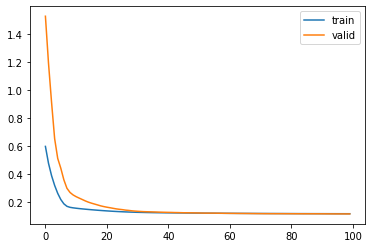

CPU times: user 59 s, sys: 6.07 s, total: 1min 5s
Wall time: 24.8 s


In [45]:
%%time
model.set_weights(weights_init)
# restoring initialized weights to have a fresh, identical fit very time model.fit() is run

# fit the autoencoder model to reconstruct input
history = model.fit(X_n_train, X_n_train, epochs=100, batch_size=128, verbose=2,
                    validation_data=(X_n_valid,X_n_valid), shuffle=False)
# plot loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.legend()
plt.show()

In [48]:
from keras.models import Model

mdl = encoder  # include here your original model

layer_name = 'activation_11'
intermediate_layer_model = Model(inputs=mdl.input,
                                 outputs=mdl.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(X_n_train)
intermediate_output

array([[0.28931677, 0.23269567, 0.5649354 , ..., 0.4992164 , 0.60004765,
        0.2658642 ],
       [0.29662883, 0.22037077, 0.6863272 , ..., 0.7225094 , 0.29230052,
        0.2344293 ],
       [0.35280502, 0.52605826, 0.6306165 , ..., 0.58668137, 0.5457447 ,
        0.42655063],
       ...,
       [0.24440056, 0.14999488, 0.5042691 , ..., 0.65062475, 0.5882465 ,
        0.21230328],
       [0.36155346, 0.8214451 , 0.41333342, ..., 0.22006696, 0.28633022,
        0.79767084],
       [0.4583155 , 0.6581113 , 0.4154228 , ..., 0.53784573, 0.6317555 ,
        0.65355825]], dtype=float32)

# Assessment

## Predicting

In [21]:
# Predict spectrum (full model):
X_n_test_pred = model.predict(X_n_test)
# Predict parameters (encoder only):
y_test_pred = encoder.predict(X_n_test)

## Comparing: reconstructed _vs_ true spectrum

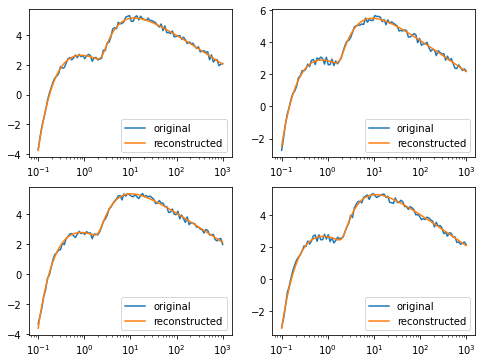

In [22]:
# Plotting a few test examples:
import random

fig, axes = plt.subplots(2,2, figsize=(8,6))
axes = axes.flatten()

for i, ax in enumerate(axes):

    j = random.randint(0, len(X_n_test))

    ax.plot(wave_mu, X_n_test[j], label='original')
    ax.plot(wave_mu, X_n_test_pred[j], label='reconstructed')
    ax.set_xscale('log')
    ax.legend()

## Comparing: encoded _vs_ true parameters

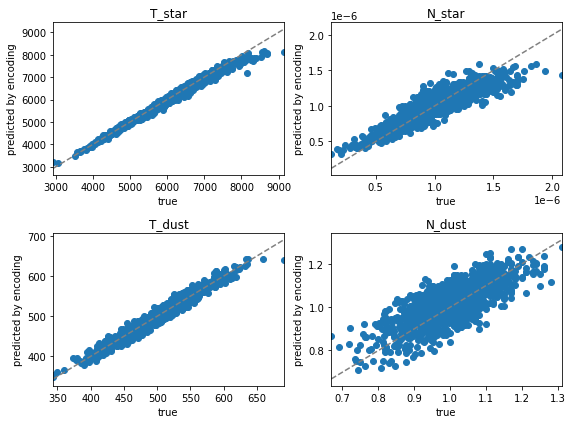

In [23]:
y_test = np.array([np.fromiter(params.values(), dtype=float) for params in Y_test])
# converting dictionary to np.array

y_params = list(Y_test[0].keys())
# parameter names: the same for all spectra (using the first)

fig, axes = plt.subplots(2,2, figsize=(8,6))
axes = axes.flatten()

for i, ax in enumerate(axes):
# i = parameter index

    if i+1 > len(y_params):
    # to delete extra panels in case we plot more than 4 parameters
        fig.delaxes(ax)

    min_ax, max_ax = np.min(y_test[:,i]), np.max(y_test[:,i])
    # 1-to-1 line:
    xx = np.linspace(min_ax, max_ax, 100)
    ax.plot(xx, xx, c="grey", linestyle='--')

    ax.scatter(y_test[:,i], y_test_pred[:,i])
    ax.set_title(y_params[i])
    ax.set_xlabel('true')
    ax.set_ylabel('predicted by encoding')
    ax.set_xlim([min_ax, max_ax])
    #ax.set_ylim([min_ax, max_ax])

    #ax.set_aspect('equal', 'box')

fig.tight_layout()
plt.show()

In [20]:
###EOF